<a href="https://colab.research.google.com/github/luthfiyahastutiningtyas/Auto-ARIMA-PSO-LSTM-GRU/blob/main/TLKM-Auto_ARIMA%2C_PSO_LSTM_%26_PSO_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Install Library yang Dibutuhkan**

In [ ]:
!pip install pmdarima
!pip install pyswarm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=a0dec75c882d92c9cb1ee9c262b784d0b67d67b51d3da0e2af403635e154cd31
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import yfinance as yf
from pmdarima import auto_arima
from pyswarm import pso
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import date, datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_percentage_error as mape
from statsmodels.tsa.arima.model import ARIMA

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import Data**

In [ ]:
stocks = ["TLKM.JK", "TBIG.JK", "TOWR.JK"]
start_date =  "2014-01-01"
end_date = "2024-01-01"
data = yf.download(stocks, start=start_date, end=end_date)
data.head(5)

[*********************100%%**********************]  3 of 3 completed


Price        Adj Close                            Close                  \
Ticker         TBIG.JK      TLKM.JK     TOWR.JK TBIG.JK TLKM.JK TOWR.JK   
Date                                                                      
2014-01-02  965.110718  1541.423584  429.595825  1210.0  2175.0   540.0   
2014-01-03  957.134705  1505.988525  429.595825  1200.0  2125.0   540.0   
2014-01-06  965.110718  1477.640381  429.595825  1210.0  2085.0   540.0   
2014-01-07  965.110718  1467.010132  426.413666  1210.0  2070.0   536.0   
2014-01-08  989.039124  1488.271118  429.595825  1240.0  2100.0   540.0   

Price         High                     Low                    Open          \
Ticker     TBIG.JK TLKM.JK TOWR.JK TBIG.JK TLKM.JK TOWR.JK TBIG.JK TLKM.JK   
Date                                                                         
2014-01-02  1210.0  2200.0   540.0  1160.0  2150.0   540.0  1180.0  2175.0   
2014-01-03  1220.0  2175.0   540.0  1160.0  2100.0   540.0  1210.0  2125.0   
2014-01-06  1220.0  2175.0   540.0  1170.0  2065.0   540.0  1220.0  2175.0   
2014-01-07  1215.0  2085.0   536.0  1180.0  2060.0   520.0  1200.0  2085.0   
2014-01-08  1245.0  2100.0   545.0  1200.0  2065.0   534.0  1200.0  2085.0   

Price                 Volume                        
Ticker     TOWR.JK   TBIG.JK     TLKM.JK   TOWR.JK  
Date                                                
2014-01-02   540.0   7512500  44446000.0   50000.0  
2014-01-03   540.0   8992500  60001000.0  280000.0  
2014-01-06   540.0  10958500  81736300.0  610500.0  
2014-01-07   520.0   6029500  73637100.0  212500.0  
2014-01-08   536.0  16130000  84514500.0  246500.0

## **Preprocessing Data**

In [ ]:
df_close = data.Close
list(df_close)
df_close.columns = ['TBIG', 'TLKM', 'TOWR']
df_close.head(5)

TBIG    TLKM   TOWR
Date                             
2014-01-02  1210.0  2175.0  540.0
2014-01-03  1200.0  2125.0  540.0
2014-01-06  1210.0  2085.0  540.0
2014-01-07  1210.0  2070.0  536.0
2014-01-08  1240.0  2100.0  540.0

In [ ]:
#statistik deskriptif
df_close.describe()

TBIG         TLKM         TOWR
count  2482.000000  2481.000000  2481.000000
mean   1622.887591  3617.390165   870.474809
std     677.014073   620.277928   193.823144
min     610.000000  2070.000000   119.199997
25%    1140.000000  3130.000000   755.000000
50%    1325.000000  3760.000000   810.000000
75%    2050.000000  4090.000000  1015.000000
max    3400.000000  4800.000000  1590.000000

In [ ]:
#Periksa tipe data
print(df_close.dtypes)

TBIG    float64
TLKM    float64
TOWR    float64
dtype: object


In [ ]:
# Cek data hilang
data_hilang=df_close.isnull()
missing = df_close.isnull().sum()
print(f"Jumlah data hilang: {missing}")
df_close.info()

Jumlah data hilang: TBIG    0
TLKM    1
TOWR    1
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2482 entries, 2014-01-02 to 2023-12-29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TBIG    2482 non-null   float64
 1   TLKM    2481 non-null   float64
 2   TOWR    2481 non-null   float64
dtypes: float64(3)
memory usage: 77.6 KB


In [ ]:
from IPython.core.display import clear_output
# Menghapus baris yang mengandung nilai NaN
modus_tlkm = df_close['TLKM'].mode()[0]
df_close['TLKM'].fillna(modus_tlkm, inplace=True)
modus_towr = df_close['TOWR'].mode()[0]
df_close['TOWR'].fillna(modus_towr, inplace=True)

clear_missing = df_close.isnull().sum()
print(f"Jumlah data hilang: {clear_missing}")
df_close.info()

Jumlah data hilang: TBIG    0
TLKM    0
TOWR    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2482 entries, 2014-01-02 to 2023-12-29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TBIG    2482 non-null   float64
 1   TLKM    2482 non-null   float64
 2   TOWR    2482 non-null   float64
dtypes: float64(3)
memory usage: 77.6 KB


<ipython-input-8-9cb536d8d3f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close['TLKM'].fillna(modus_tlkm, inplace=True)
<ipython-input-8-9cb536d8d3f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close['TOWR'].fillna(modus_towr, inplace=True)


In [ ]:
# Periksa apakah ada tanggal yang duplikat
duplicate_dates = df_close[df_close.index.duplicated(keep=False)]
print("Tanggal duplikat:\n", duplicate_dates)

Tanggal duplikat:
 Empty DataFrame
Columns: [TBIG, TLKM, TOWR]
Index: []


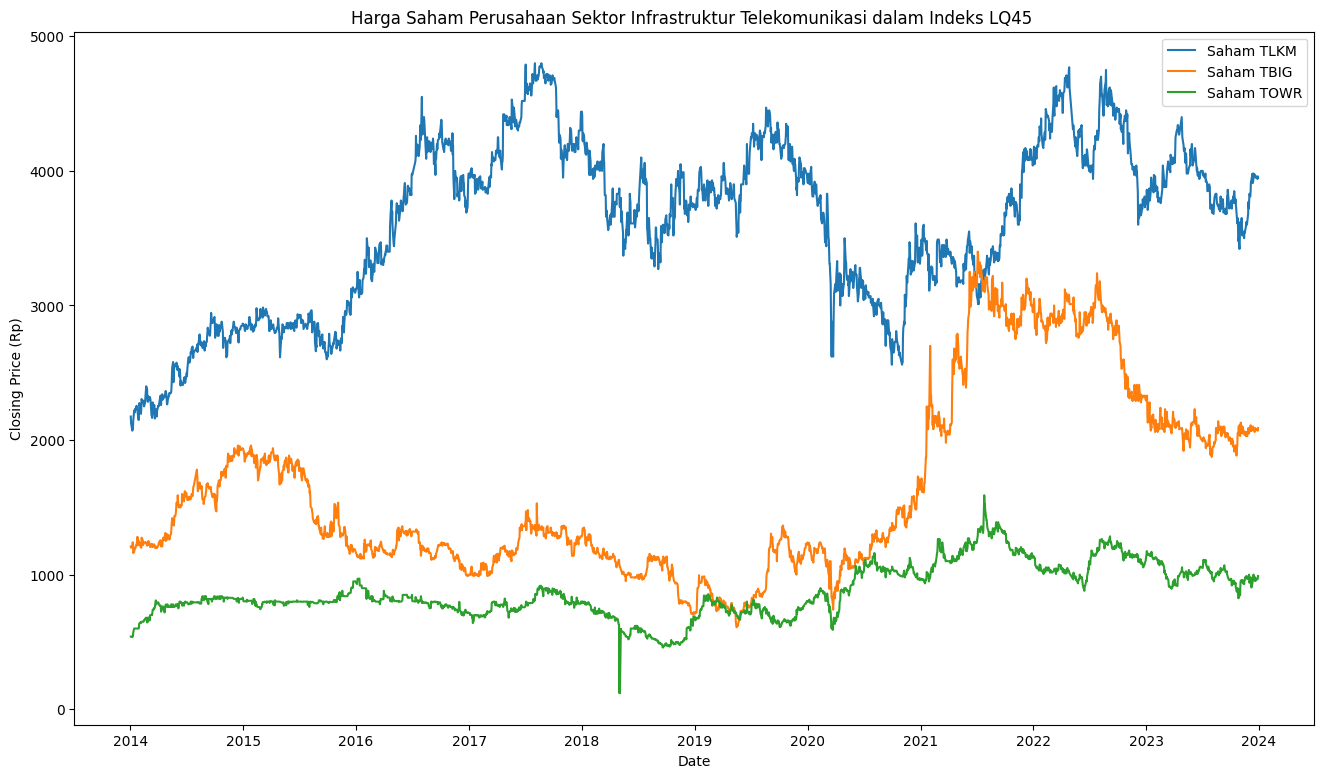

In [ ]:
# Plot data
fig, ax = plt.subplots(figsize=(16,9))
for name in ['TLKM', 'TBIG', 'TOWR']:
    ax.plot(df_close[name].index, df_close[name], label='Saham {}'.format(name))

ax.set_title('Harga Saham Perusahaan Sektor Infrastruktur Telekomunikasi dalam Indeks LQ45 ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (Rp)')
ax.legend()

In [ ]:
split_data = df_close.shape[0] * 0.8

df_train = df_close[:int(split_data)]
df_test = df_close[int(split_data):]

#Checking dataset shape
print("df_train: ", df_train.shape)
print(df_train)
print("df_test: ", df_test.shape)
print(df_test)

df_train:  (1985, 3)
              TBIG    TLKM    TOWR
Date                              
2014-01-02  1210.0  2175.0   540.0
2014-01-03  1200.0  2125.0   540.0
2014-01-06  1210.0  2085.0   540.0
2014-01-07  1210.0  2070.0   536.0
2014-01-08  1240.0  2100.0   540.0
...            ...     ...     ...
2021-12-08  3080.0  4090.0  1130.0
2021-12-09  3180.0  4150.0  1135.0
2021-12-10  3200.0  4150.0  1145.0
2021-12-13  3140.0  4080.0  1145.0
2021-12-14  3100.0  4100.0  1125.0

[1985 rows x 3 columns]
df_test:  (497, 3)
              TBIG    TLKM    TOWR
Date                              
2021-12-15  3090.0  4080.0  1130.0
2021-12-16  3130.0  4100.0  1120.0
2021-12-17  3090.0  4100.0  1115.0
2021-12-20  3090.0  4080.0  1140.0
2021-12-21  3040.0  4160.0  1140.0
...            ...     ...     ...
2023-12-21  2070.0  3950.0   955.0
2023-12-22  2080.0  3960.0   965.0
2023-12-27  2080.0  3940.0   965.0
2023-12-28  2070.0  3960.0   970.0
2023-12-29  2090.0  3950.0   990.0

[497 rows x 3 columns]


---
# **PT. Telkom Indonesia Tbk (TLKM)**
---

###**Splitting Data**

In [ ]:
#Split Dataset Training 80% & Testing 20%
data_tlkm = df_close['TLKM']
data_tlkm.index=data_tlkm.index.date
split_data = data_tlkm.shape[0] * 0.8

df_train_tlkm = data_tlkm[:int(split_data)]
df_test_tlkm = data_tlkm[int(split_data):]

#Checking dataset shape
print("df_train_tlkm: ", df_train_tlkm.shape)
print(df_train_tlkm)
print("df_test_tlkm: ", df_test_tlkm.shape)
print(df_test_tlkm)

df_train_tlkm:  (1985,)
2014-01-02    2175.0
2014-01-03    2125.0
2014-01-06    2085.0
2014-01-07    2070.0
2014-01-08    2100.0
               ...  
2021-12-08    4090.0
2021-12-09    4150.0
2021-12-10    4150.0
2021-12-13    4080.0
2021-12-14    4100.0
Name: TLKM, Length: 1985, dtype: float64
df_test_tlkm:  (497,)
2021-12-15    4080.0
2021-12-16    4100.0
2021-12-17    4100.0
2021-12-20    4080.0
2021-12-21    4160.0
               ...  
2023-12-21    3950.0
2023-12-22    3960.0
2023-12-27    3940.0
2023-12-28    3960.0
2023-12-29    3950.0
Name: TLKM, Length: 497, dtype: float64


---
## **Auto ARIMA**
---

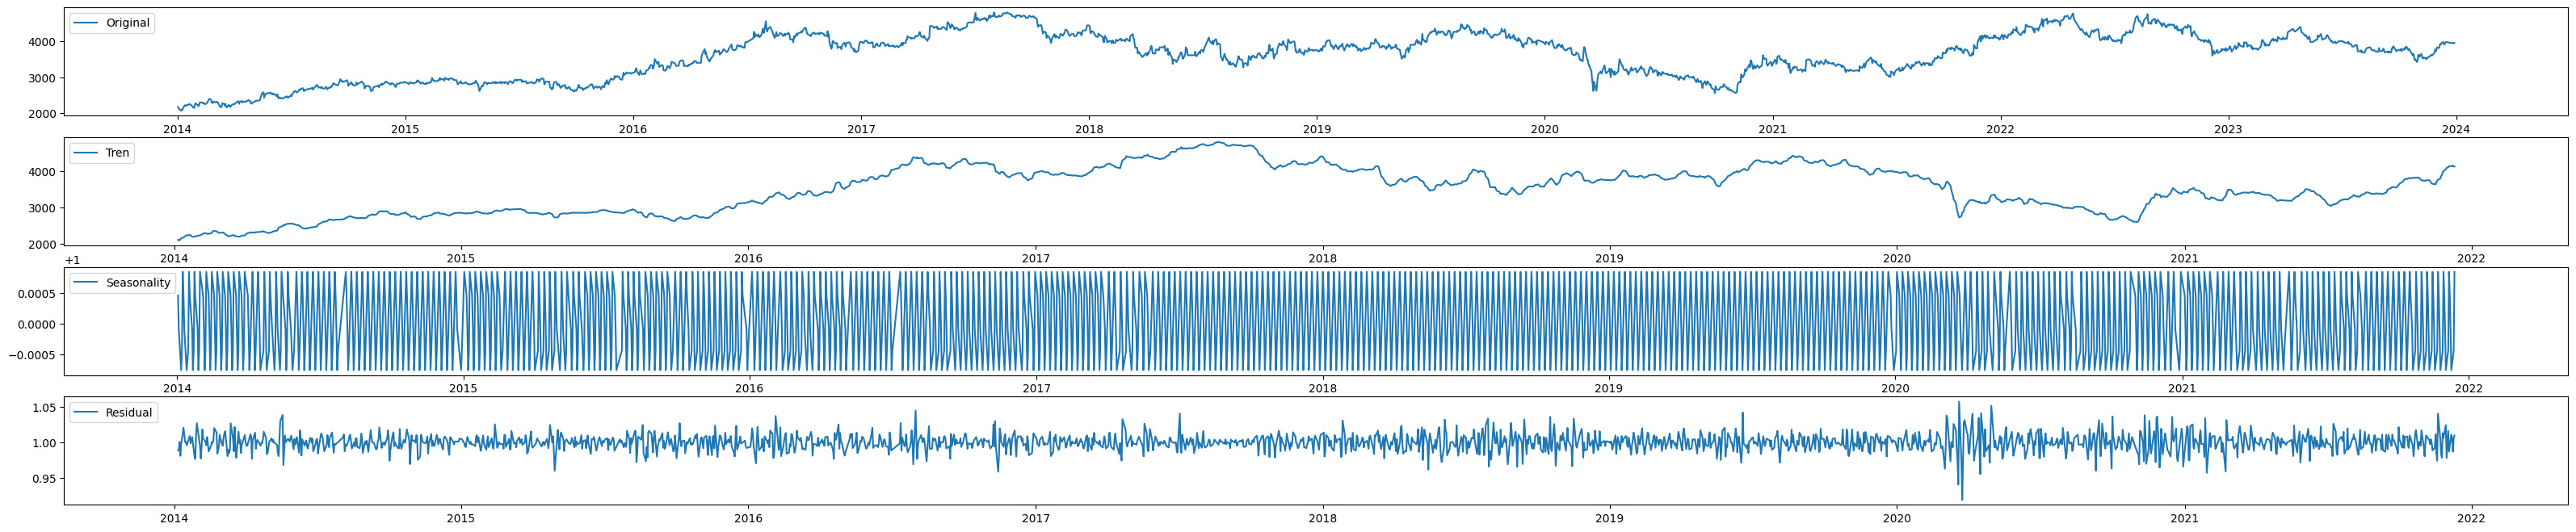

In [ ]:
#Dekomposisi
from statsmodels.tsa.seasonal import seasonal_decompose

dekomposisi = seasonal_decompose(df_train_tlkm, model='multiplicative', period=5)  # Atau 'multiplicative'
trend = dekomposisi.trend
seasonal = dekomposisi.seasonal
residu = dekomposisi.resid
fig, ax = plt.subplots(4, 1, figsize=(40, 8))
ax[0].plot(data_tlkm, label='Original')
ax[0].legend(loc='upper left')
ax[1].plot(trend, label='Tren')
ax[1].legend(loc='upper left')
ax[2].plot(seasonal, label='Seasonality')
ax[2].legend(loc='upper left')
ax[3].plot(residu, label='Residual')
ax[3].legend(loc='upper left')
plt.show()

In [ ]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

df_test = adfuller(df_train_tlkm, autolag='AIC')
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   -2.341090
p-value                           0.159058
#Lags Used                        4.000000
Number of Observations Used    1980.000000
Critical Value (1%)              -3.433657
Critical Value (5%)              -2.863001
Critical Value (10%)             -2.567548
dtype: float64


p-value sebesar 0.159058 lebih dari 0.05 maka data tidak stasioner

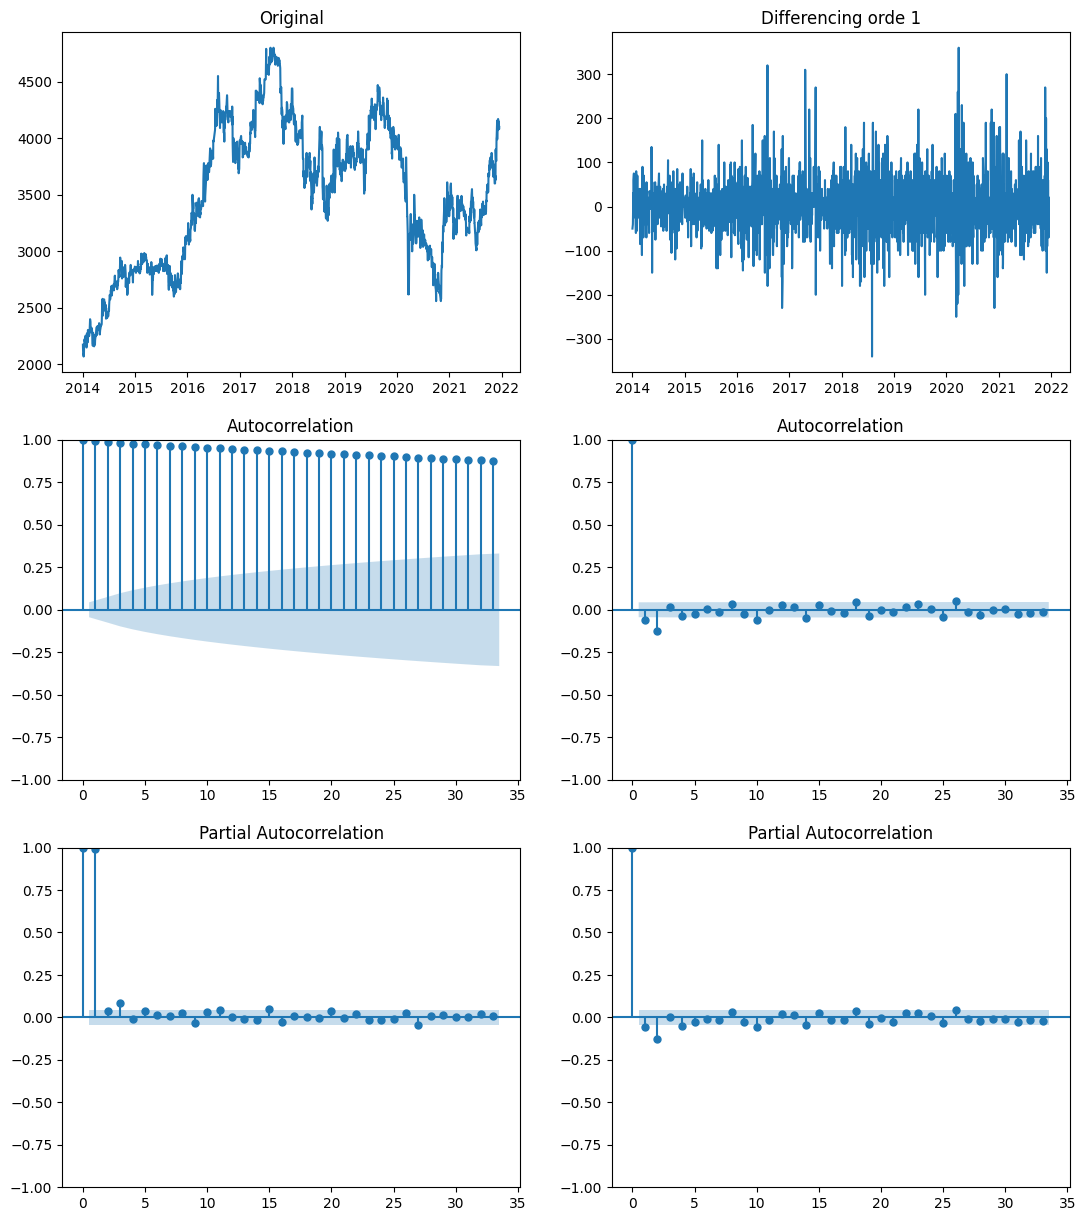

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, figsize=(13,15))
axes[0, 0].plot(df_train_tlkm)
axes[0, 0].set_title('Original')
#Differencing orde 1
axes[0, 1].plot(df_train_tlkm.diff())
axes[0, 1].set_title('Differencing orde 1')

#ACF plot untuk menentukan q (MA)
plot_acf(df_train_tlkm, ax=axes[1, 0])
plot_acf(df_train_tlkm.diff().dropna(), ax=axes[1, 1])

#PACF plot untuk menentukan p (AR)
plot_pacf(df_train_tlkm, ax=axes[2,0])
plot_pacf(df_train_tlkm.diff().dropna(), ax=axes[2,1])

plt.show()

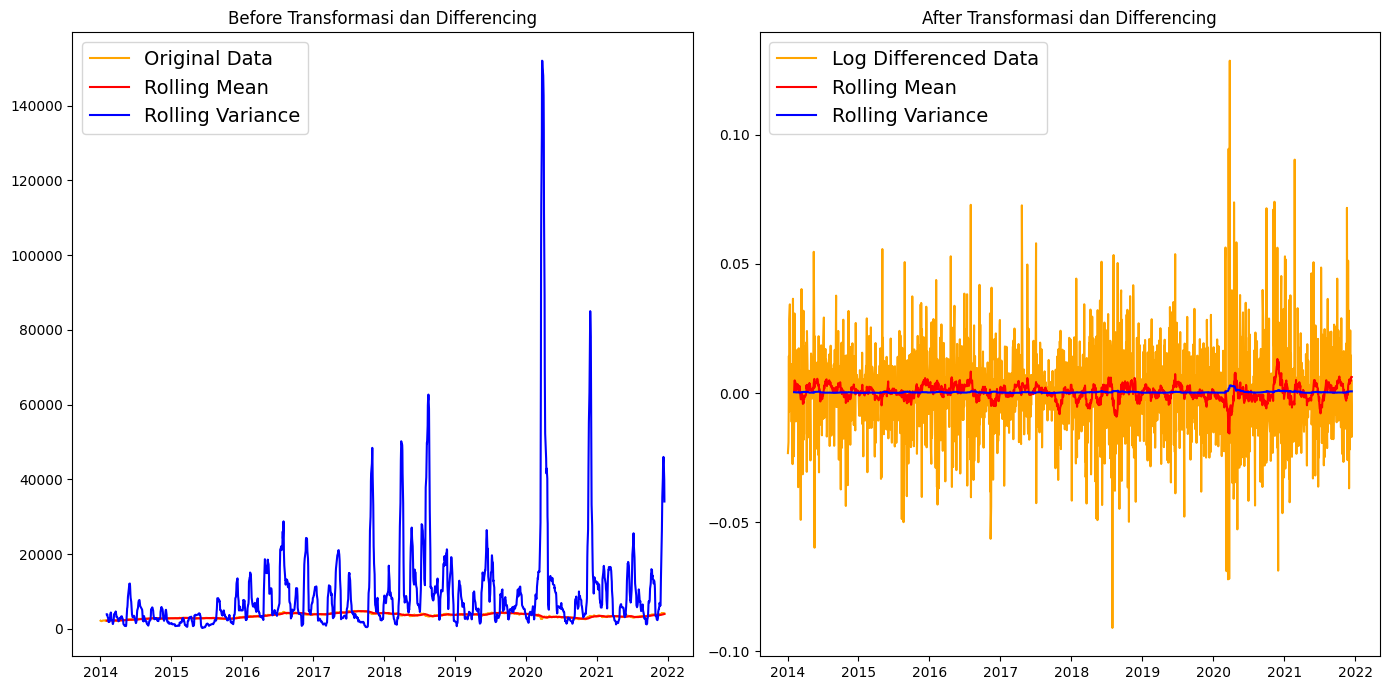

In [ ]:
#Rolling mean dan rolling varians
rolling_mean = df_train_tlkm.rolling(21).mean()
rolling_var = df_train_tlkm.rolling(21).var()

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].plot(df_train_tlkm, color='orange', label='Original Data')
ax[0].plot(rolling_mean, color='red', label='Rolling Mean')
ax[0].plot(rolling_var, color='blue', label='Rolling Variance')
ax[0].set_title('Before Transformasi dan Differencing')
ax[0].legend(loc='upper left', fontsize=14)

# Transformasi logaritmik
data_log = np.log(df_train_tlkm)
data_log_diff = data_log.diff().dropna()

#Rolling mean dan rolling varians
rolling_mean = data_log_diff.rolling(21).mean()
rolling_var = data_log_diff.rolling(21).var()

ax[1].plot(data_log_diff, color='orange', label='Log Differenced Data')
ax[1].plot(rolling_mean, color='red', label='Rolling Mean')
ax[1].plot(rolling_var, color='blue', label='Rolling Variance')
ax[1].set_title('After Transformasi dan Differencing')
ax[1].legend(loc='upper left', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

#Differencing orde 1
df_test = adfuller(data_log_diff, autolag='AIC')
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -25.135190
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1980.000000
Critical Value (1%)              -3.433657
Critical Value (5%)              -2.863001
Critical Value (10%)             -2.567548
dtype: float64


p-value sebesar 0.0000 kurang dari 0.05 maka data stasioner

In [ ]:
start_time = time.time()
Model_auto_arima = auto_arima(data_log, trace=True, stepwise=True,
                              error_action='ignore', supress_warnings=True,
                              seasonal=False, stationary=False, start_p=0, start_q=0,
                              d=1, max_p=5, max_q=5)
end_time = time.time()
Model_auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10337.887, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10341.676, Time=0.74 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10343.524, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10339.252, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10366.310, Time=9.92 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10375.065, Time=2.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10376.401, Time=0.63 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-10374.759, Time=1.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-10372.655, Time=1.26 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-10377.451, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10342.967, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-10375.838, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-10376.153, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10366.945, Time=1.99 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1985
Model:               SARIMAX(2, 1, 0)   Log Likelihood                5191.725
Date:                Mon, 12 Aug 2024   AIC                         -10377.451
Time:                        10:37:25   BIC                         -10360.672
Sample:                             0   HQIC                        -10371.288
                               - 1985                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0616      0.016     -3.934      0.000      -0.092      -0.031
ar.L2         -0.1350      0.016     -8.527      0.000      -0.166      -0.104
sigma2         0.0003   5.93e-06     52.614      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1119.76
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
fitted = Model_auto_arima.predict_in_sample()
fitted_values = np.exp(fitted)

In [ ]:
import statsmodels.api as sm
residuals = Model_auto_arima.resid()
ljung_box_results = sm.stats.acorr_ljungbox(residuals, lags=[2], return_df=True)
print('Ljung-Box Test Results:')
print(ljung_box_results)

Ljung-Box Test Results:
    lb_stat  lb_pvalue
2  0.033116   0.983578


Nilai lb_pvalue sebesar 0.983578 lebih besar dari 0.05 menunjukkan bahwa model Auto ARIMA berhasil menangkap semua pola dalam data dan residual dari model tersebut adalah white noise.

In [ ]:
prediksi = Model_auto_arima.predict(n_periods= len(df_test_tlkm))
prediksi_autoarima = np.exp(prediksi)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


####**Evaluasi Model**



In [ ]:
#Evaluasi Train Data
r2_train_autoarima = r2_score(df_train_tlkm, fitted_values)
rmse_train_autoarima = np.sqrt(mse(df_train_tlkm, fitted_values))
mape_train_autoarima = mape(df_train_tlkm, fitted_values) * 100
print('R2 pada Train Data :', r2_train_autoarima)
print('RMSE pada Train Data :', rmse_train_autoarima)
print('MAPE pada Train Data :', mape_train_autoarima)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_autoarima = r2_score(df_test_tlkm, prediksi_autoarima)
rmse_test_autoarima = np.sqrt(mse(df_test_tlkm, prediksi_autoarima))
mape_test_autoarima = mape(df_test_tlkm, prediksi_autoarima) * 100
print('R2 pada Train Data :', r2_test_autoarima)
print('RMSE pada Train Data :', rmse_test_autoarima)
print('MAPE pada Train Data :', mape_test_autoarima)
print("------------------------------------------")
print("Training time: "  + str(end_time - start_time))

R2 pada Train Data : 0.9843775451951801
RMSE pada Train Data : 78.08300384239615
MAPE pada Train Data : 1.3014867383595579
------------------------------------------
R2 pada Train Data : -0.0048109209754727544
RMSE pada Train Data : 300.93604702359875
MAPE pada Train Data : 6.232055399384033
------------------------------------------
Training time: 22.215845823287964


####**Comparison Real vs Prediction**

In [ ]:
tabel_fitted_autoarima = pd.DataFrame({'Date': df_train_tlkm.index,  'Data Train': df_train_tlkm.values, 'Fitted Values':  fitted_values})
folder_autoarima = '/content/drive/My Drive/skripsi/auto arima/autoarima_tlkm_fitted.csv'
tabel_fitted_autoarima.to_csv(folder_autoarima, index=False, mode='w')
tabel_fitted_autoarima = pd.read_csv('/content/drive/My Drive/skripsi/auto arima/autoarima_tlkm_fitted.csv')
tabel_fitted_autoarima

Date  Data Train  Fitted Values
0     2014-01-02      2175.0       1.000000
1     2014-01-03      2125.0    2175.000000
2     2014-01-06      2085.0    2127.683664
3     2014-01-07      2070.0    2094.005330
4     2014-01-08      2100.0    2076.239770
...          ...         ...            ...
1980  2021-12-08      4090.0    4137.649788
1981  2021-12-09      4150.0    4096.327946
1982  2021-12-10      4150.0    4154.438053
1983  2021-12-13      4080.0    4141.849749
1984  2021-12-14      4100.0    4084.277215

[1985 rows x 3 columns]

In [ ]:
tabel_prediksi_autoarima = pd.DataFrame({'Date':df_test_tlkm.index, 'Test' : df_test_tlkm.values, 'Prediksi Auto ARIMA': prediksi_autoarima})
folder_autoarima = '/content/drive/My Drive/skripsi/auto arima/autoarima_tlkm_results.csv'
tabel_prediksi_autoarima.to_csv(folder_autoarima, index=False, mode='w')
tabel_prediksi_autoarima = pd.read_csv('/content/drive/My Drive/skripsi/auto arima/autoarima_tlkm_results.csv')
tabel_prediksi_autoarima

Date    Test  Prediksi Auto ARIMA
0    2021-12-15  4080.0          4108.188069
1    2021-12-16  4100.0          4104.972767
2    2021-12-17  4100.0          4104.065321
3    2021-12-20  4080.0          4104.554992
4    2021-12-21  4160.0          4104.647324
..          ...     ...                  ...
492  2023-12-21  3950.0          4104.576911
493  2023-12-22  3960.0          4104.576911
494  2023-12-27  3940.0          4104.576911
495  2023-12-28  3960.0          4104.576911
496  2023-12-29  3950.0          4104.576911

[497 rows x 3 columns]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


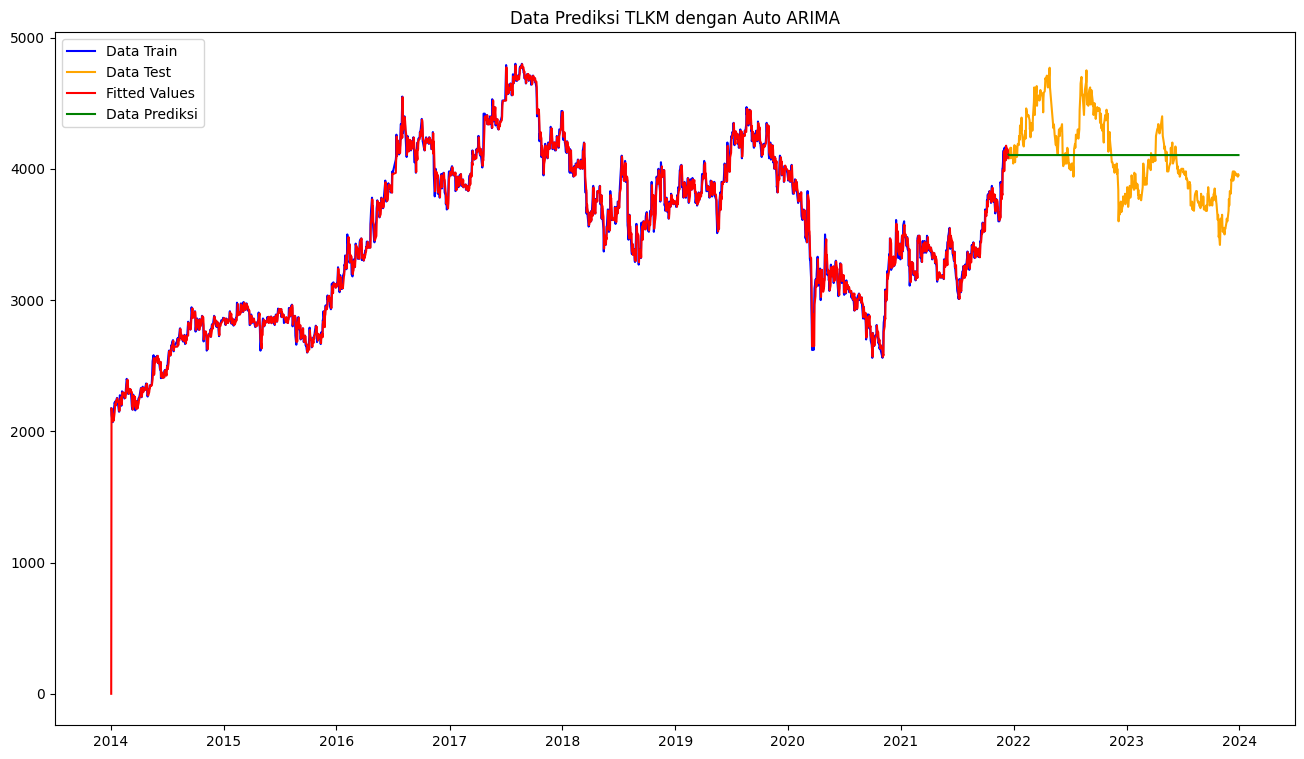

In [ ]:
#Plot data prediksi
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_tlkm, color="blue", label='Data Train')
plt.plot(df_test_tlkm, color="orange", label='Data Test')
plt.plot(df_train_tlkm.index, fitted_values, color="red", label='Fitted Values')
plt.plot(df_test_tlkm.index, prediksi_autoarima, color="green",  label='Data Prediksi')
plt.title('Data Prediksi TLKM dengan Auto ARIMA')
plt.legend(loc="upper left")

from google.colab import drive
drive.mount('/content/drive')
plot_auto_arima = '/content/drive/My Drive/skripsi/auto arima/auto_arima_tlkm.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_auto_arima)
plt.show()


---
## **LSTM**
---

### **Function**

####**Normalisasi Data**

In [ ]:
def normalize_data(df_train_tlkm, df_test_tlkm):
  scaler = MinMaxScaler(feature_range = (0,1))
  train_data_tlkm_norm = scaler.fit_transform(df_train_tlkm.values.reshape(-1,1))
  test_data_tlkm_norm = scaler.transform(df_test_tlkm.values.reshape(-1,1))
  return scaler, train_data_tlkm_norm, test_data_tlkm_norm

####**Window Size**

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        Y.append(data[i + window_size, 0])
    X = np.array(X).reshape(len(X), window_size, 1)
    Y = np.array(Y).reshape(len(Y), 1)
    return X, Y

### **Build Model**

####**Normalisasi Data**

In [ ]:
scaler, train_data_tlkm_norm, test_data_tlkm_norm = normalize_data(df_train_tlkm, df_test_tlkm)

In [ ]:
tabel_data_train_norm_tlkm = pd.DataFrame(train_data_tlkm_norm, columns=['Data Train Normalisasi'], index=df_train_tlkm.index)
tabel_data_train_norm_tlkm

Data Train Normalisasi
2014-01-02                0.038462
2014-01-03                0.020147
2014-01-06                0.005495
2014-01-07                0.000000
2014-01-08                0.010989
...                            ...
2021-12-08                0.739927
2021-12-09                0.761905
2021-12-10                0.761905
2021-12-13                0.736264
2021-12-14                0.743590

[1985 rows x 1 columns]

In [ ]:
tabel_data_test_norm_tlkm = pd.DataFrame(test_data_tlkm_norm, columns=['Data Test Normalisasi'], index=df_test_tlkm.index)
tabel_data_test_norm_tlkm

Data Test Normalisasi
2021-12-15               0.736264
2021-12-16               0.743590
2021-12-17               0.743590
2021-12-20               0.736264
2021-12-21               0.765568
...                           ...
2023-12-21               0.688645
2023-12-22               0.692308
2023-12-27               0.684982
2023-12-28               0.692308
2023-12-29               0.688645

[497 rows x 1 columns]

####**Hyperparameter Tuning**

In [ ]:
params = (20, 50, 10, 32)
window_size_lstm = int(params[0])
hidden_layer_lstm = int( params[1])
epochs_lstm = int( params[2])
batch_size_lstm = int( params[3])
print('Window size: ', window_size_lstm)
print('Hidden layer: ', hidden_layer_lstm)
print('Epoch: ', epochs_lstm)
print('Batch size: ', batch_size_lstm)

Window size:  20
Hidden layer:  50
Epoch:  10
Batch size:  32


In [ ]:
X_train_lstm, Y_train_lstm = prepare_dataset(train_data_tlkm_norm, window_size_lstm)
X_test_lstm, Y_test_lstm = prepare_dataset(test_data_tlkm_norm, window_size_lstm)
print("X_train: ", X_train_lstm.shape)
print("Y_train: ", Y_train_lstm.shape)
print("X_test: ", X_test_lstm.shape)
print("Y_test", Y_test_lstm.shape)

X_train:  (1964, 20, 1)
Y_train:  (1964, 1)
X_test:  (476, 20, 1)
Y_test (476, 1)


In [ ]:
#LSTM model
start_time = time.time()
final_model_lstm = Sequential()
final_model_lstm.add(LSTM(units=int(hidden_layer_lstm), input_shape=(X_train_lstm.shape[1], 1),
                 activation='tanh', dropout=0.2))
final_model_lstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.0001)
final_model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

#Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                   restore_best_weights=True)

#Train model
final_model_lstm.fit(X_train_lstm, Y_train_lstm, epochs=int(epochs_lstm), batch_size=int(batch_size_lstm),
            validation_data=(X_test_lstm, Y_test_lstm), callbacks=[early_stopping])
end_time = time.time()
#Predictions
y_train_pred_lstm = final_model_lstm.predict(X_train_lstm)
y_test_pred_lstm = final_model_lstm.predict(X_test_lstm)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.2223 - val_loss: 0.1381
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0754 - val_loss: 0.0163
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0446 - val_loss: 0.0175
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0435 - val_loss: 0.0189
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0417 - val_loss: 0.0177
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0415 - val_loss: 0.0206
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0400 - val_loss: 0.0195
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


####**Denormalisasi Data**

In [ ]:
# Transform back to original form
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm.reshape(-1,1))
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm.reshape(-1,1))
Y_train_lstm = scaler.inverse_transform(Y_train_lstm.reshape(-1,1))
Y_test_lstm = scaler.inverse_transform(Y_test_lstm.reshape(-1,1))

####**Evaluasi Model**

In [ ]:
#Evaluasi Train Data
r2_train_lstm = r2_score(Y_train_lstm, y_train_pred_lstm)
rmse_train_lstm = np.sqrt(mse(Y_train_lstm, y_train_pred_lstm))
mape_train_lstm = mape(Y_train_lstm, y_train_pred_lstm) * 100
training_lstm = str(end_time - start_time)
print('R2 pada Train Data :', r2_train_lstm)
print('RMSE pada Train Data :', rmse_train_lstm)
print('MAPE pada Train Data :', mape_train_lstm)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_lstm = r2_score(Y_test_lstm, y_test_pred_lstm)
rmse_test_lstm = np.sqrt(mse(Y_test_lstm, y_test_pred_lstm))
mape_test_lstm = mape(Y_test_lstm, y_test_pred_lstm) * 100
print('R2 pada Test Data :', r2_test_lstm)
print('RMSE pada Test Data :', rmse_test_lstm)
print('MAPE pada Test Data :', mape_test_lstm)
print("------------------------------------------")
print("Training time: ", training_lstm)

R2 pada Train Data : 0.960127
RMSE pada Train Data : 122.496334
MAPE pada Train Data : 2.844803
------------------------------------------
R2 pada Test Data : 0.844055
RMSE pada Test Data : 121.058621
MAPE pada Test Data : 2.285555
------------------------------------------
Training time:  11.465160131454468


In [ ]:

results_lstm = pd.read_csv('/content/drive/My Drive/skripsi/lstm/tlkm/lstm_results.csv')
results_lstm

Window Size  Hidden Layers  Epochs  Batch Size  R2 Train  RMSE Train  \
0           10             25      10          32  0.922217  172.572526   
1           10             50      10          32  0.941348  149.853951   
2           15             50      10          32  0.926730  166.803814   
3           15             50      10          32  0.955812  129.537693   
4           20             25      10          32  0.928385  164.167661   
5           20             50      10          32  0.960127  122.496334   

   MAPE Train   R2 Test   RMSE Test  MAPE Test  
0    4.422278  0.735149  156.185219   2.795247  
1    3.805619  0.797406  136.600594   2.532032  
2    4.208868  0.750111  152.462059   2.818654  
3    3.094639  0.823851  128.005652   2.375775  
4    4.100685  0.773287  145.964766   2.745772  
5    2.844803  0.844055  121.058621   2.285555

###**Comparison Real vs Prediction**

In [ ]:
split_data = data_tlkm.shape[0] * 0.8
data_train_lstm = data_tlkm[window_size_lstm + 1:int(split_data)]
tabel_data_train = pd.DataFrame({'Date': data_train_lstm.index,  'Data Train': data_train_lstm.values})
prediksi_train_lstm = pd.DataFrame({'Prediksi Data Train LSTM':  y_train_pred_lstm.flatten()})
tabel_prediksi_train_lstm = pd.concat([tabel_data_train, prediksi_train_lstm], axis = 1)
folder_lstm = '/content/drive/My Drive/skripsi/lstm/tlkm/train/lstm_6.csv'
tabel_prediksi_train_lstm.to_csv(folder_lstm, index=False, mode='a')
tabel_prediksi_train_lstm

Date  Data Train  Prediksi Data Train LSTM
0     2014-02-04      2195.0               2336.943359
1     2014-02-05      2235.0               2339.501221
2     2014-02-06      2305.0               2340.373047
3     2014-02-07      2295.0               2344.410889
4     2014-02-10      2295.0               2353.863525
...          ...         ...                       ...
1959  2021-12-08      4090.0               3937.800781
1960  2021-12-09      4150.0               3960.791504
1961  2021-12-10      4150.0               3977.663818
1962  2021-12-13      4080.0               3998.103516
1963  2021-12-14      4100.0               4016.834961

[1964 rows x 3 columns]

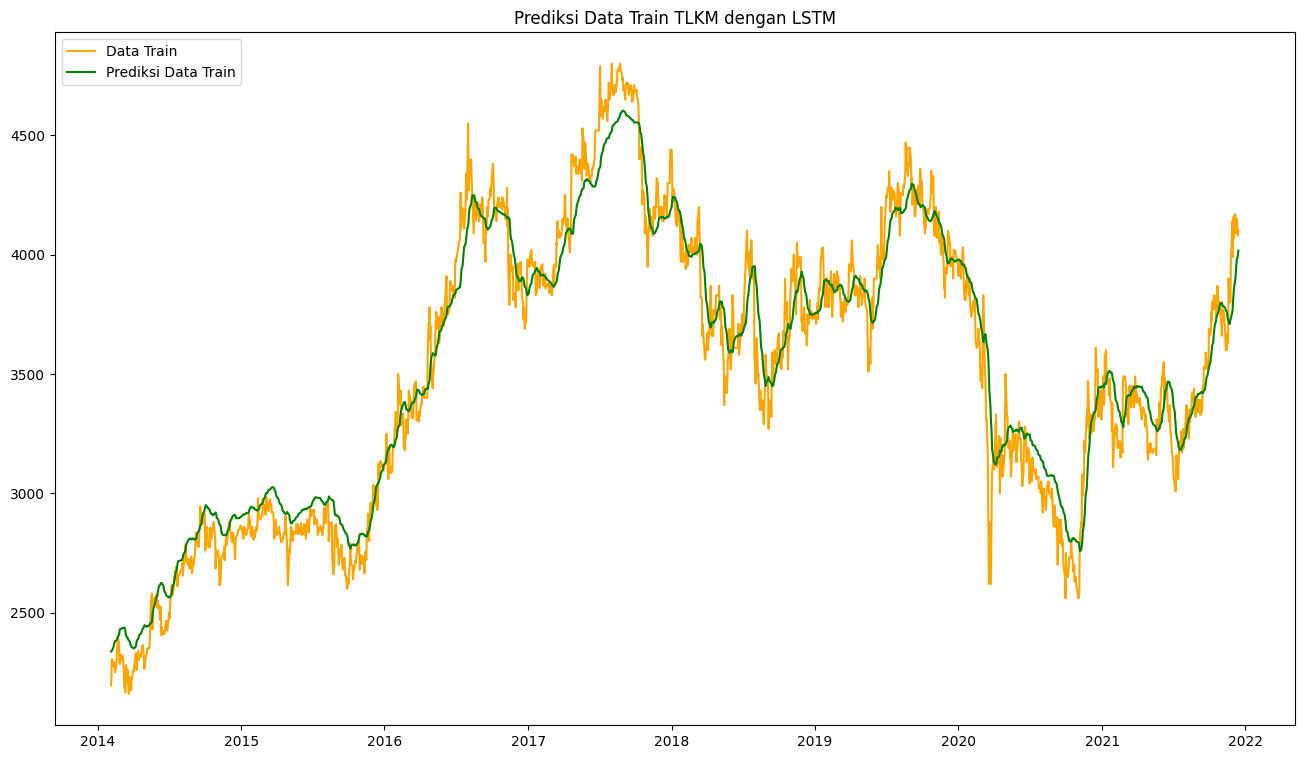

In [ ]:
#plot the predictions for train set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_train_lstm.index, data_train_lstm, color="orange", label='Data Train')
plt.plot(data_train_lstm.index, y_train_pred_lstm, color="green", label='Prediksi Data Train')
plt.title('Prediksi Data Train TLKM dengan LSTM')
plt.legend(loc="upper left")
plot_train_lstm = '/content/drive/My Drive/skripsi/lstm/tlkm/train/tlkm_train_lstm_6.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_train_lstm)
plt.show()

In [ ]:
split_data = data_tlkm.shape[0] * 0.8
data_test_lstm = data_tlkm[window_size_lstm + 1 + int(split_data):]
tabel_data_test = pd.DataFrame({'Date': data_test_lstm.index, 'Data Test': data_test_lstm.values})
prediksi_test_lstm = pd.DataFrame({'Prediksi Data Test LSTM':  y_test_pred_lstm.flatten()})
tabel_prediksi_test_lstm = pd.concat([tabel_data_test, prediksi_test_lstm], axis = 1)
folder_lstm = '/content/drive/My Drive/skripsi/lstm/tlkm/test/lstm_6.csv'
tabel_prediksi_test_lstm.to_csv(folder_lstm, index=False, mode='a')
tabel_prediksi_test_lstm

Date  Data Test  Prediksi Data Test LSTM
0    2022-01-14     4190.0              4081.678467
1    2022-01-17     4180.0              4087.202637
2    2022-01-18     4250.0              4092.817627
3    2022-01-19     4250.0              4097.663574
4    2022-01-20     4220.0              4107.897949
..          ...        ...                      ...
471  2023-12-21     3950.0              3891.207764
472  2023-12-22     3960.0              3902.072266
473  2023-12-27     3940.0              3911.197998
474  2023-12-28     3960.0              3919.798096
475  2023-12-29     3950.0              3925.156982

[476 rows x 3 columns]

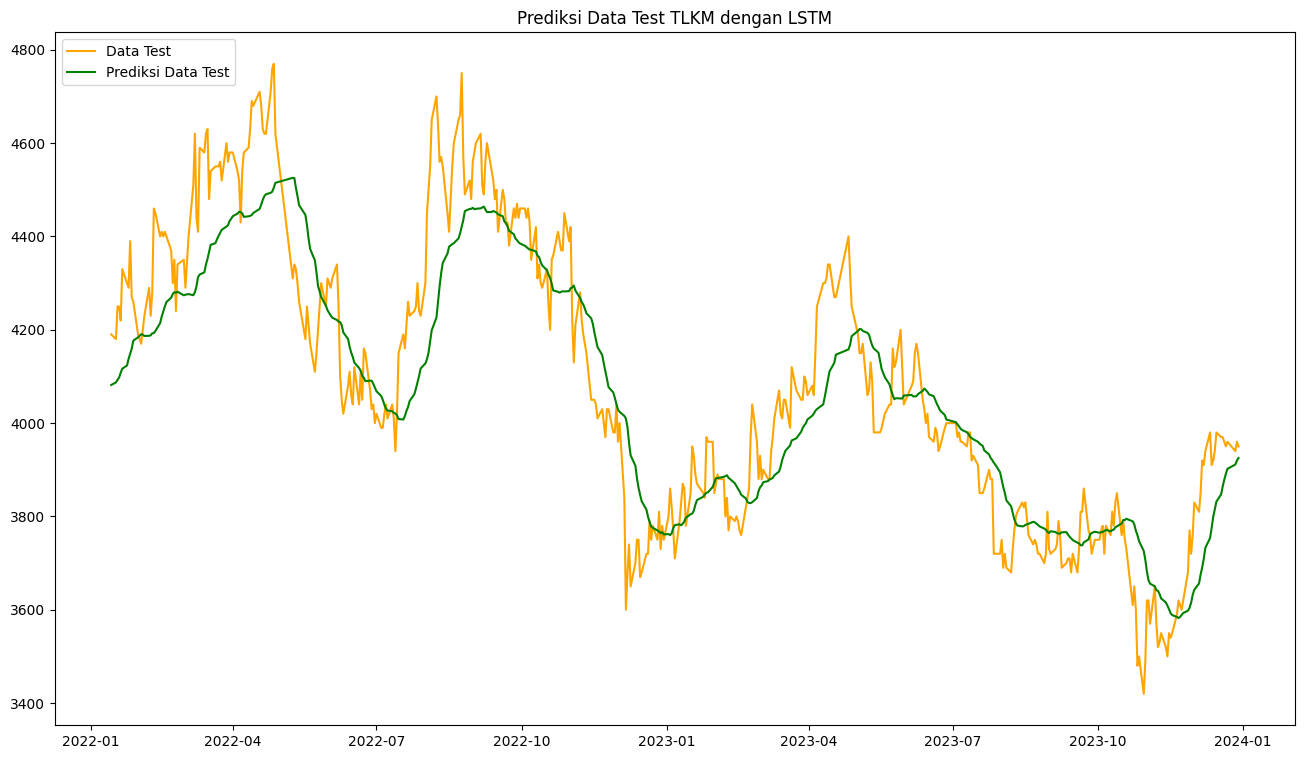

In [ ]:
#plot the predictions for test set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_test_lstm.index, data_test_lstm, color="orange", label='Data Test')
plt.plot(data_test_lstm.index, y_test_pred_lstm, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data Test TLKM dengan LSTM')
plt.legend(loc="upper left")
plot_test_lstm = '/content/drive/My Drive/skripsi/lstm/tlkm/test/tlkm_test_lstm_6.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_test_lstm)
plt.show()

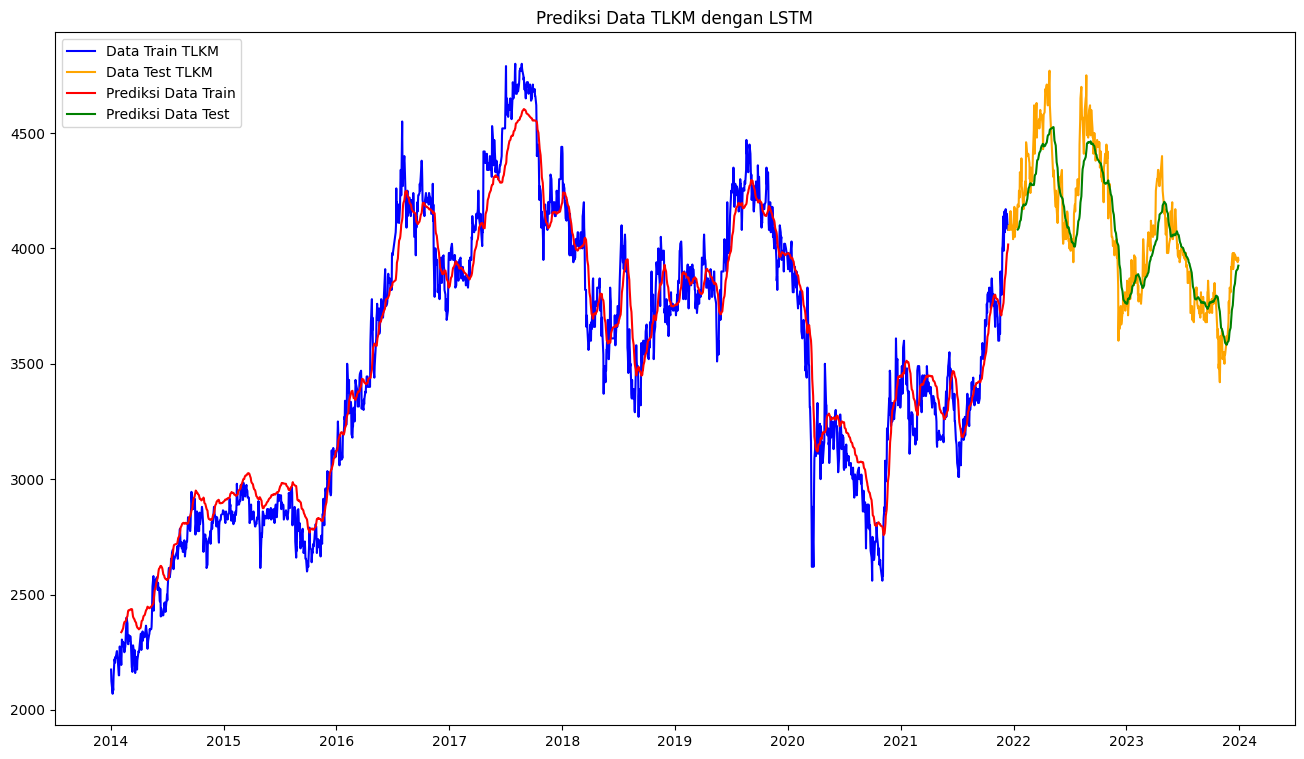

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_tlkm, color="blue", label='Data Train TLKM')
plt.plot(df_test_tlkm, color="orange", label='Data Test TLKM')
plt.plot(data_train_lstm.index, y_train_pred_lstm, color="red", label='Prediksi Data Train')
plt.plot(data_test_lstm.index, y_test_pred_lstm, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data TLKM dengan LSTM')
plt.legend(loc="upper left")
plot_lstm = '/content/drive/My Drive/skripsi/lstm/tlkm/plot_lstm_6.png'
plt.savefig(plot_lstm)
plt.show()

---
## **PSO-LSTM**
---

### **Function**

####**Normalisasi Data**

In [ ]:
def normalize_data(df_train_tlkm, df_test_tlkm):
  scaler = MinMaxScaler(feature_range = (0,1))
  train_data_tlkm_norm = scaler.fit_transform(df_train_tlkm.values.reshape(-1,1))
  test_data_tlkm_norm = scaler.transform(df_test_tlkm.values.reshape(-1,1))
  return scaler, train_data_tlkm_norm, test_data_tlkm_norm

####**Window Size**

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        Y.append(data[i + window_size, 0])
    X = np.array(X).reshape(len(X), window_size, 1)
    Y = np.array(Y).reshape(len(Y), 1)
    return X, Y

####**Objective function for PSO-LSTM**

In [ ]:
# Objective function for PSO (minimize RMSE)
def objective_function_lstm(params, X_train, Y_train, scaler, X_test, Y_test):
  window_size, hidden_layers, epochs, batch_size = params
  print('window_size', window_size, ', hidden_layers', hidden_layers,
        ', epochs', epochs, ', batch_size', batch_size)

  if window_size == 0 or batch_size == 0:
        return 10,

  #LSTM model
  model = Sequential()
  model.add(LSTM(units=int(hidden_layers), input_shape=(X_train.shape[1], 1),
                 activation='tanh', dropout=0.2))
  model.add(Dense(units=1))
  optimizer = Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss='mean_squared_error')
  #Early Stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                   restore_best_weights=True)

  #Train model
  model.fit(X_train, Y_train, epochs=int(epochs), batch_size=int(batch_size),
            validation_data=(X_test, Y_test), callbacks=[early_stopping])

  #Predictions
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  #RMSE
  rmse = np.sqrt(mse(Y_train, y_train_pred))
  print('Validation RMSE: ', rmse,'\n')
  return rmse

### **Build Model**

####**Normalisasi Data**

In [ ]:
scaler, train_data_tlkm_norm, test_data_tlkm_norm = normalize_data(df_train_tlkm, df_test_tlkm)

####**PSO hyperparameter tuning**

In [ ]:
lb = [10, 25, 1, 1] # Lower bounds for the parameters
ub = [20, 50, 10, 32] #Upper bounds for the parameters

In [ ]:
X_train_psolstm, Y_train_psolstm = prepare_dataset(train_data_tlkm_norm, lb[0])
X_test_psolstm, Y_test_psolstm = prepare_dataset(test_data_tlkm_norm, lb[0])
print("X_train: ", X_train_psolstm.shape)
print("Y_train: ", Y_train_psolstm.shape)
print("X_test: ", X_test_psolstm.shape)
print("Y_test", Y_test_psolstm.shape)

X_train:  (1974, 10, 1)
Y_train:  (1974, 1)
X_test:  (486, 10, 1)
Y_test (486, 1)


In [ ]:
#Run PSO to optimize hyperparameters
start_time = time.time()
best_params_psolstm, best_value_psolstm = pso(objective_function_lstm, lb, ub,
                                              args=(X_train_psolstm, Y_train_psolstm, scaler,
                                                    X_test_psolstm, Y_test_psolstm),
                                              swarmsize=5, maxiter=5)
end_time = time.time()
# Print the best parameters found by PSO
print('Best Parameters:', best_params_psolstm)
print('RMSE:', best_value_psolstm)

window_size 17.115602591331506 , hidden_layers 48.30091163721223 , epochs 3.638389331001387 , batch_size 12.008181630447556
Epoch 1/3
165/165 [==============================] - 5s 14ms/step - loss: 0.1241 - val_loss: 0.0069
Epoch 2/3
165/165 [==============================] - 1s 9ms/step - loss: 0.0089 - val_loss: 0.0036
Epoch 3/3
16/16 [==============================] - 0s 4ms/step
Validation RMSE:  0.05690825616726639 

window_size 10.934388087407012 , hidden_layers 46.4638347625786 , epochs 6.780480580301245 , batch_size 15.614464670542086
Epoch 1/6
132/132 [==============================] - 4s 14ms/step - loss: 0.0872 - val_loss: 0.0105
Epoch 2/6
132/132 [==============================] - 1s 9ms/step - loss: 0.0090 - val_loss: 0.0034
Epoch 3/6
132/132 [==============================] - 1s 9ms/step - loss: 0.0082 - val_loss: 0.0027
Epoch 4/6
132/132 [==============================] - 1s 11ms/step - loss: 0.0081 - val_loss: 0.0026
Epoch 5/6
132/132 [==============================] - 

In [ ]:
optimal_window_size_psolstm = int(best_params_psolstm[0])
optimal_hidden_layer_psolstm = int(best_params_psolstm[1])
optimal_epochs_psolstm = int(best_params_psolstm[2])
optimal_batch_size_psolstm = int(best_params_psolstm[3])
print('Optimal window size: ', optimal_window_size_psolstm)
print('Optimal hidden layers: ', optimal_hidden_layer_psolstm)
print('Optimal epoch: ', optimal_epochs_psolstm)
print('Optimal batch size: ', optimal_batch_size_psolstm)

Optimal window size:  10
Optimal hidden layers:  25
Optimal epoch:  5
Optimal batch size:  1


In [ ]:
X_train_psolstm, Y_train_psolstm = prepare_dataset(train_data_tlkm_norm, optimal_window_size_psolstm)
X_test_psolstm, Y_test_psolstm = prepare_dataset(test_data_tlkm_norm, optimal_window_size_psolstm)
print("X_train: ", X_train_psolstm.shape)
print("Y_train: ", Y_train_psolstm.shape)
print("X_test: ", X_test_psolstm.shape)
print("Y_test", Y_test_psolstm.shape)

X_train:  (1974, 10, 1)
Y_train:  (1974, 1)
X_test:  (486, 10, 1)
Y_test (486, 1)


In [ ]:
final_model_psolstm = Sequential()
final_model_psolstm.add(LSTM(units=optimal_hidden_layer_psolstm,
                             input_shape=(X_train_psolstm.shape[1], 1),
                             activation='tanh', dropout=0.2))
final_model_psolstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.0001)
final_model_psolstm.compile(optimizer=optimizer, loss='mean_squared_error')
final_model_psolstm.fit(X_train_psolstm, Y_train_psolstm, epochs=optimal_epochs_psolstm,
                        batch_size=optimal_batch_size_psolstm,
                        validation_data=(X_test_psolstm, Y_test_psolstm))
y_train_pred_psolstm = final_model_psolstm.predict(X_train_psolstm)
y_test_pred_psolstm = final_model_psolstm.predict(X_test_psolstm)

Epoch 1/5
1974/1974 [==============================] - 16s 7ms/step - loss: 0.0223 - val_loss: 0.0024
Epoch 2/5
1974/1974 [==============================] - 14s 7ms/step - loss: 0.0084 - val_loss: 0.0017
Epoch 3/5
1974/1974 [==============================] - 14s 7ms/step - loss: 0.0089 - val_loss: 0.0037
Epoch 4/5
1974/1974 [==============================] - 14s 7ms/step - loss: 0.0074 - val_loss: 0.0042
Epoch 5/5
16/16 [==============================] - 0s 4ms/step


####**Denormalisasi Data**

In [ ]:
# Transform back to original form
y_train_pred_psolstm = scaler.inverse_transform(y_train_pred_psolstm.reshape(-1,1))
y_test_pred_psolstm = scaler.inverse_transform(y_test_pred_psolstm.reshape(-1,1))
Y_train_psolstm = scaler.inverse_transform(Y_train_psolstm.reshape(-1,1))
Y_test_psolstm = scaler.inverse_transform(Y_test_psolstm.reshape(-1,1))

####**Evaluasi Model**

In [ ]:
def mape(df_test_tbig, prediksi):
    return np.mean(np.abs((df_test_tbig - prediksi) / df_test_tbig)) * 100

#Evaluasi Train Data
r2_train_psolstm = r2_score(Y_train_psolstm, y_train_pred_psolstm)
rmse_train_psolstm = np.sqrt(mse(Y_train_psolstm, y_train_pred_psolstm))
mae_train_psolstm = mae(Y_train_psolstm, y_train_pred_psolstm)
mape_train_psolstm = mape(Y_train_psolstm, y_train_pred_psolstm)
print('R2 pada Train Data :', r2_train_psolstm)
print('RMSE pada Train Data :', rmse_train_psolstm)
print('MAE pada Train Data :', mae_train_psolstm)
print('MAPE pada Train Data :', mape_train_psolstm)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_psolstm = r2_score(Y_test_psolstm, y_test_pred_psolstm)
rmse_test_psolstm = np.sqrt(mse(Y_test_psolstm, y_test_pred_psolstm))
mae_test_psolstm = mae(Y_test_psolstm, y_test_pred_psolstm)
mape_test_psolstm = mape(Y_test_psolstm, y_test_pred_psolstm)
print('R2 pada Test Data :', r2_test_psolstm)
print('RMSE pada Test Data :', rmse_test_psolstm)
print('MAE pada Test Data :', mae_test_psolstm)
print('MAPE pada Test Data :', mape_test_psolstm)
print("Training time: "  + str(end_time - start_time))

R2 pada Train Data : 0.9572524989901032
RMSE pada Train Data : 127.9333186074364
MAE pada Train Data : 100.7701240392683
MAPE pada Train Data : 2.941762636371426
------------------------------------------
R2 pada Test Data : 0.8041153577498644
RMSE pada Test Data : 134.31961208554685
MAE pada Test Data : 102.5583320272312
MAPE pada Test Data : 2.435255755224048
Training time: 1162.0623905658722
R2 pada Train Data : 0.9572524989901032
RMSE pada Train Data : 127.9333186074364
MAE pada Train Data : 100.7701240392683
MAPE pada Train Data : 2.941762636371426
------------------------------------------
R2 pada Test Data : 0.8041153577498644
RMSE pada Test Data : 134.31961208554685
MAE pada Test Data : 102.5583320272312
MAPE pada Test Data : 2.435255755224048
Training time: 1162.0623905658722


In [ ]:
params_psolstm = {
    'Window Size': optimal_window_size_psolstm,
    'Hidden Layers': optimal_hidden_layer_psolstm,
    'Epochs': optimal_epochs_psolstm,
    'Batch Size': optimal_batch_size_psolstm,
    'R2 Train': r2_train_psolstm,
    'RMSE Train': rmse_train_psolstm,
    'MAE Train': mae_train_psolstm,
    'MAPE Train': mape_train_psolstm,
    'R2 Test': r2_test_psolstm,
    'RMSE Test': rmse_test_psolstm,
    'MAE Test': mae_test_psolstm,
    'MAPE Test': mape_test_psolstm
}

results_psolstm = pd.DataFrame([params_psolstm])
folder_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/tlkm/psolstm_results.csv'
results_psolstm.to_csv(folder_psolstm, index=False, mode='a', header=False)
results_psolstm = pd.read_csv('/content/drive/My Drive/skripsi/pso-lstm/tlkm/psolstm_results.csv')
results_psolstm

Window Size  Hidden Layers  Epochs  Batch Size  R2 Train  RMSE Train  \
0           18             44       9           1  0.955896  129.043279   
1           19             35       7           1  0.950861  136.094791   
2           10             25       5           1  0.957252  127.933319   

    MAE Train  MAPE Train   R2 Test   RMSE Test    MAE Test  MAPE Test  
0   97.281704    2.783616  0.794078  138.820701  108.910265   2.609372  
1  100.642830    2.774283  0.718839  162.380865  124.751170   2.948261  
2  100.770124    2.941763  0.804115  134.319612  102.558332   2.435256

###**Comparison Real vs Prediction**

In [ ]:
split_data = data_tlkm.shape[0] * 0.8
data_train_psolstm = data_tlkm[optimal_window_size_psolstm + 1:int(split_data)]
tabel_data_train = pd.DataFrame({'Date': data_train_psolstm.index,  'Data Train': data_train_psolstm.values})
prediksi_train_psolstm = pd.DataFrame({'Prediksi Data Train PSO-LSTM':  y_train_pred_psolstm.flatten()})
tabel_prediksi_train_psolstm = pd.concat([tabel_data_train, prediksi_train_psolstm], axis = 1)
folder_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/tlkm/train/psolstm_3.csv'
tabel_prediksi_train_psolstm.to_csv(folder_psolstm, index=False, mode='a')
tabel_prediksi_train_psolstm

Date  Data Train  Prediksi Data Train PSO-LSTM
0    2014-01-20      2250.0                   2243.540771
1    2014-01-21      2255.0                   2250.061768
2    2014-01-22      2230.0                   2263.140625
3    2014-01-23      2225.0                   2279.840332
4    2014-01-24      2210.0                   2295.082031
...         ...         ...                           ...
1969 2021-12-08      4090.0                   3995.216064
1970 2021-12-09      4150.0                   4020.886475
1971 2021-12-10      4150.0                   4041.336426
1972 2021-12-13      4080.0                   4053.335938
1973 2021-12-14      4100.0                   4063.422363

[1974 rows x 3 columns]

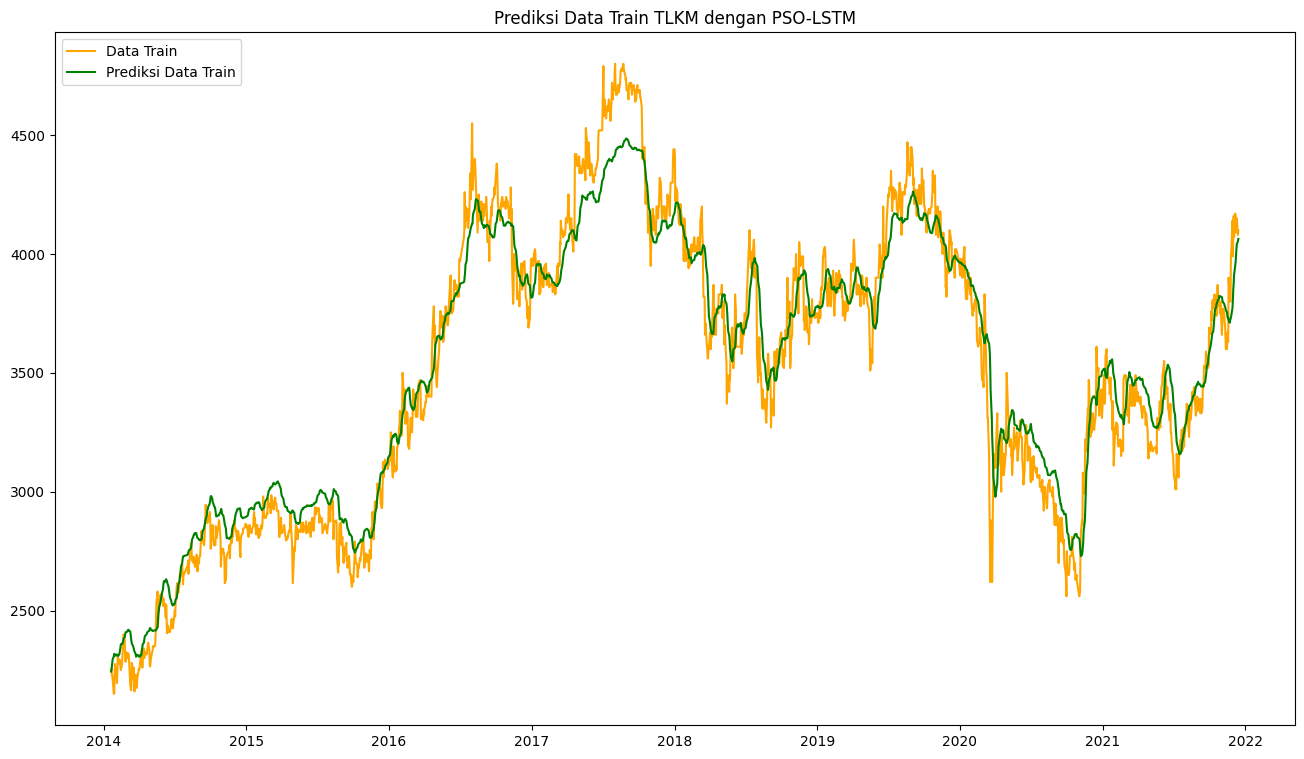

In [ ]:
#plot the predictions for train set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_train_psolstm.index, data_train_psolstm, color="orange", label='Data Train')
plt.plot(data_train_psolstm.index, y_train_pred_psolstm, color="green", label='Prediksi Data Train')
plt.title('Prediksi Data Train TLKM dengan PSO-LSTM')
plt.legend(loc="upper left")
plot_train_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/tlkm/train/tlkm_train_psolstm_3.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_train_psolstm)
plt.show()

In [ ]:
split_data = data_tlkm.shape[0] * 0.8
data_test_psolstm = data_tlkm[optimal_window_size_psolstm + 1 + int(split_data):]
tabel_data_test = pd.DataFrame({'Date': data_test_psolstm.index, 'Data Test': data_test_psolstm.values})
prediksi_test_psolstm = pd.DataFrame({'Prediksi Data Test PSO-LSTM':  y_test_pred_psolstm.flatten()})
tabel_prediksi_test_psolstm = pd.concat([tabel_data_test, prediksi_test_psolstm], axis = 1)
folder_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/tlkm/test/psolstm_3.csv'
tabel_prediksi_test_psolstm.to_csv(folder_psolstm, index=False, mode='a')
tabel_prediksi_test_psolstm

Date  Data Test  Prediksi Data Test PSO-LSTM
0   2021-12-30     4040.0                  4057.371582
1   2022-01-03     4180.0                  4057.424561
2   2022-01-04     4170.0                  4052.747314
3   2022-01-05     4050.0                  4060.251221
4   2022-01-06     4120.0                  4065.840332
..         ...        ...                          ...
481 2023-12-21     3950.0                  3933.965820
482 2023-12-22     3960.0                  3936.969238
483 2023-12-27     3940.0                  3940.019287
484 2023-12-28     3960.0                  3941.806885
485 2023-12-29     3950.0                  3938.723389

[486 rows x 3 columns]

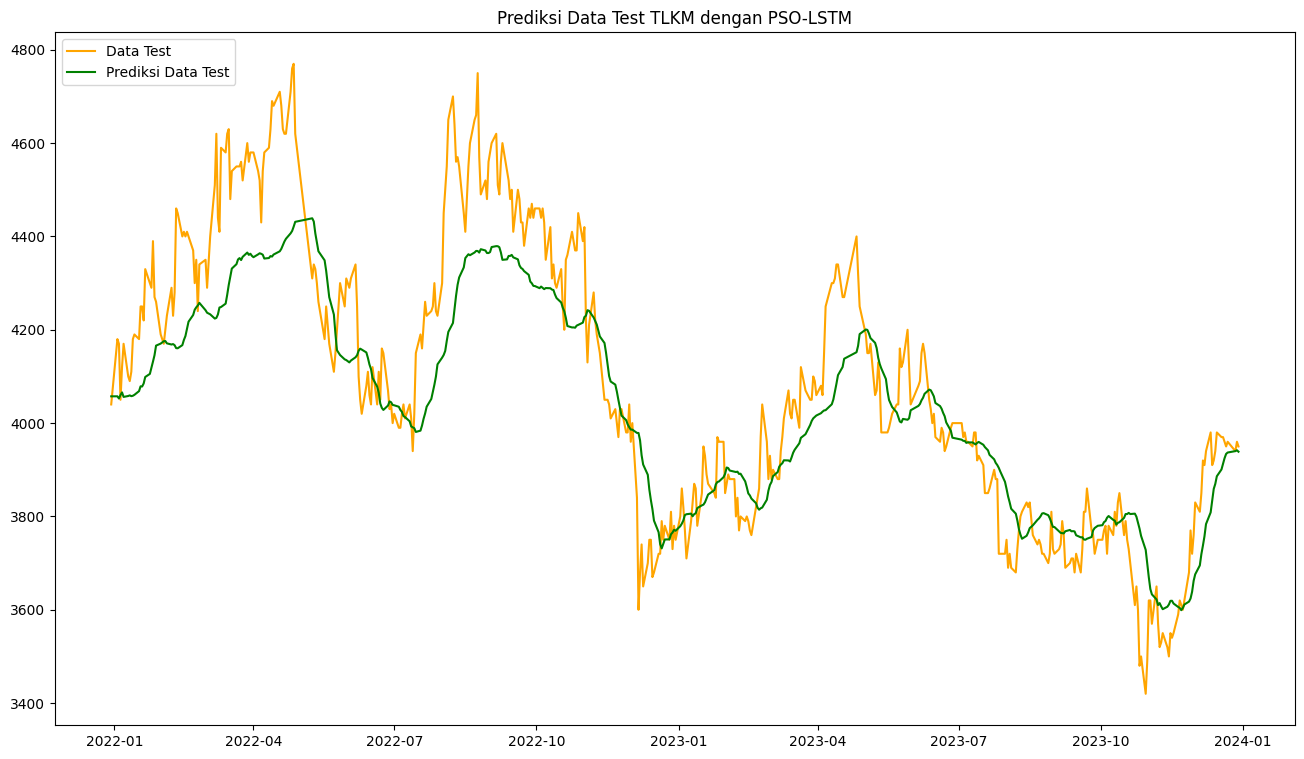

In [ ]:
#plot the predictions for test set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_test_psolstm.index, data_test_psolstm, color="orange", label='Data Test')
plt.plot(data_test_psolstm.index, y_test_pred_psolstm, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data Test TLKM dengan PSO-LSTM')
plt.legend(loc="upper left")
plot_test_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/tlkm/test/tlkm_test_psolstm_3.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_test_psolstm)
plt.show()

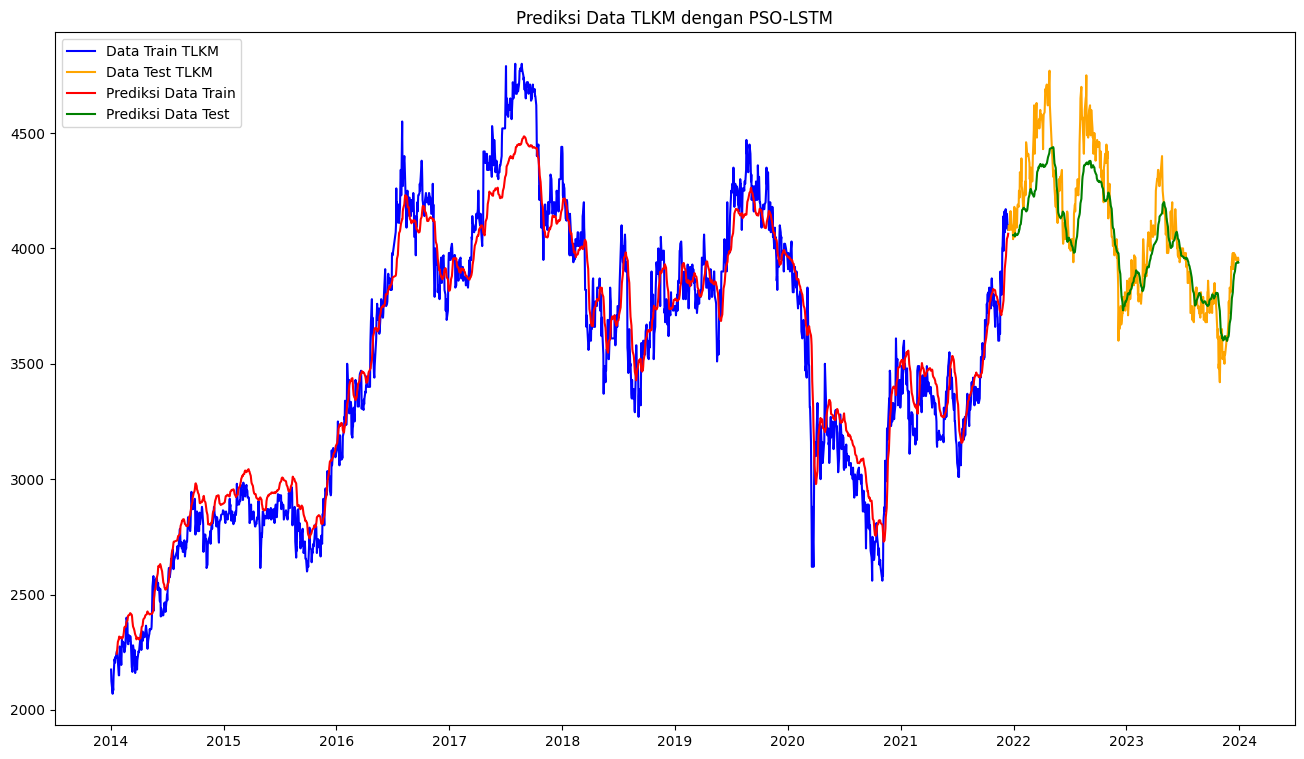

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_tlkm, color="blue", label='Data Train TLKM')
plt.plot(df_test_tlkm, color="orange", label='Data Test TLKM')
plt.plot(data_train_psolstm.index, y_train_pred_psolstm, color="red", label='Prediksi Data Train')
plt.plot(data_test_psolstm.index, y_test_pred_psolstm, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data TLKM dengan PSO-LSTM')
plt.legend(loc="upper left")
plot_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/tlkm/plot_psolstm_3.png'
plt.savefig(plot_psolstm)
plt.show()

---
## **GRU**
---

### **Function**

####**Normalisasi Data**

In [ ]:
def normalize_data(df_train_tlkm, df_test_tlkm):
  scaler = MinMaxScaler(feature_range = (0,1))
  train_data_tlkm_norm = scaler.fit_transform(df_train_tlkm.values.reshape(-1,1))
  test_data_tlkm_norm = scaler.transform(df_test_tlkm.values.reshape(-1,1))
  return scaler, train_data_tlkm_norm, test_data_tlkm_norm

####**Window Size**

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        Y.append(data[i + window_size, 0])
    X = np.array(X).reshape(len(X), window_size, 1)
    Y = np.array(Y).reshape(len(Y), 1)
    return X, Y

### **Build Model**

####**Normalisasi Data**

In [ ]:
scaler, train_data_tlkm_norm, test_data_tlkm_norm = normalize_data(df_train_tlkm, df_test_tlkm)

####**Hyperparameter tuning**

In [ ]:
params = (20, 50, 10, 32)
window_size_gru = int(params[0])
hidden_layer_gru = int( params[1])
epochs_gru = int( params[2])
batch_size_gru = int( params[3])
print('Window size: ', window_size_gru)
print('Hidden layer: ', hidden_layer_gru)
print('Epochs: ', epochs_gru)
print('Batch Size: ', batch_size_gru)

Window size:  20
Hidden layer:  50
Epochs:  10
Batch Size:  32


In [ ]:
X_train_gru, Y_train_gru = prepare_dataset(train_data_tlkm_norm, window_size_gru)
X_test_gru, Y_test_gru = prepare_dataset(test_data_tlkm_norm, window_size_gru)
print("X_train: ", X_train_gru.shape)
print("Y_train: ", Y_train_gru.shape)
print("X_test: ", X_test_gru.shape)
print("Y_test", Y_test_gru.shape)

X_train:  (1964, 20, 1)
Y_train:  (1964, 1)
X_test:  (476, 20, 1)
Y_test (476, 1)


In [ ]:
#GRU model
final_model_gru = Sequential()
final_model_gru.add(GRU(units=int(hidden_layer_gru), input_shape=(X_train_gru.shape[1], 1),
                 activation='tanh', dropout=0.2))
final_model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.0001)
final_model_gru.compile(optimizer=optimizer, loss='mean_squared_error')

#Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                   restore_best_weights=True)

#Train model
final_model_gru.fit(X_train_gru, Y_train_gru, epochs=50, batch_size=32,
            validation_data=(X_test_gru, Y_test_gru), callbacks=[early_stopping])

#Predictions
y_train_pred_gru = final_model_gru.predict(X_train_gru)
y_test_pred_gru = final_model_gru.predict(X_test_gru)

Epoch 1/50
62/62 [==============================] - 6s 31ms/step - loss: 0.2610 - val_loss: 0.2946
Epoch 2/50
62/62 [==============================] - 1s 12ms/step - loss: 0.1020 - val_loss: 0.0944
Epoch 3/50
62/62 [==============================] - 1s 12ms/step - loss: 0.0261 - val_loss: 0.0132
Epoch 4/50
62/62 [==============================] - 1s 12ms/step - loss: 0.0130 - val_loss: 0.0067
Epoch 5/50
62/62 [==============================] - 1s 12ms/step - loss: 0.0120 - val_loss: 0.0068
Epoch 6/50
62/62 [==============================] - 1s 12ms/step - loss: 0.0114 - val_loss: 0.0053
Epoch 7/50
62/62 [==============================] - 1s 11ms/step - loss: 0.0103 - val_loss: 0.0052
Epoch 8/50
62/62 [==============================] - 1s 12ms/step - loss: 0.0100 - val_loss: 0.0041
Epoch 9/50
62/62 [==============================] - 1s 12ms/step - loss: 0.0088 - val_loss: 0.0034
Epoch 10/50
62/62 [==============================] - 1s 12ms/step - loss: 0.0087 - val_loss: 0.0038
Epoch 11/

####**Denormalisasi Data**

In [ ]:
# Transform back to original form
y_train_pred_gru = scaler.inverse_transform(y_train_pred_gru.reshape(-1,1))
y_test_pred_gru = scaler.inverse_transform(y_test_pred_gru.reshape(-1,1))
Y_train_gru = scaler.inverse_transform(Y_train_gru.reshape(-1,1))
Y_test_gru = scaler.inverse_transform(Y_test_gru.reshape(-1,1))

####**Evaluasi Model**

In [ ]:
def mape(df_test_tlkm, prediksi):
    return np.mean(np.abs((df_test_tlkm - prediksi) / df_test_tlkm)) * 100

#Evaluasi Train Data
r2_train_gru = r2_score(Y_train_gru, y_train_pred_gru)
rmse_train_gru = np.sqrt(mse(Y_train_gru, y_train_pred_gru))
mae_train_gru = mae(Y_train_gru, y_train_pred_gru)
mape_train_gru = mape(Y_train_gru, y_train_pred_gru)
print('R2 pada Train Data :', r2_train_gru)
print('RMSE pada Train Data :', rmse_train_gru)
print('MAE pada Train Data :', mae_train_gru)
print('MAPE pada Train Data :', mape_train_gru)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_gru = r2_score(Y_test_gru, y_test_pred_gru)
rmse_test_gru = np.sqrt(mse(Y_test_gru, y_test_pred_gru))
mae_test_gru = mae(Y_test_gru, y_test_pred_gru)
mape_test_gru = mape(Y_test_gru, y_test_pred_gru)
print('R2 pada Test Data :', r2_test_gru)
print('RMSE pada Test Data :', rmse_test_gru)
print('MAE pada Test Data :', mae_test_gru)
print('MAPE pada Test Data :', mape_test_gru)
print("Training time: "  + str(end_time - start_time))

R2 pada Train Data : 0.9541879758133998
RMSE pada Train Data : 131.30343388196283
MAE pada Train Data : 104.94630547113671
MAPE pada Train Data : 3.2028995911183835
------------------------------------------
R2 pada Test Data : 0.8427057388173721
RMSE pada Test Data : 121.5810329331534
MAE pada Test Data : 93.9784233029149
MAPE pada Test Data : 2.2629561540671963
Training time: 89.772616147995


In [ ]:
params_gru = {
    'Window Size': window_size_gru,
    'Hidden Layers': hidden_layer_gru,
    'Epochs': epochs_gru,
    'Batch Size': batch_size_gru,
    'R2 Train': r2_train_gru,
    'RMSE Train': rmse_train_gru,
    'MAE Train': mae_train_gru,
    'MAPE Train': mape_train_gru,
    'R2 Test': r2_test_gru,
    'RMSE Test': rmse_test_gru,
    'MAE Test': mae_test_gru,
    'MAPE Test': mape_test_gru
}

results_gru = pd.DataFrame([params_gru])
folder_gru = '/content/drive/My Drive/skripsi/gru/tlkm/gru_results.csv'
results_gru.to_csv(folder_gru, index=False, mode='a', header=False)
results_gru = pd.read_csv('/content/drive/My Drive/skripsi/gru/tlkm/gru_results.csv')
results_gru

Window Size  Hidden Layers  Epochs  Batch Size  R2 Train  RMSE Train  \
0           10             25      10          32  0.945074  145.017068   
1           10             50      10          32  0.952515  134.835900   
2           15             25      10          32  0.950981  136.433897   
3           15             50      10          32  0.960617  122.290974   
4           20             25      10          32  0.959474  123.495952   
5           20             50      10          32  0.954188  131.303434   

    MAE Train  MAPE Train   R2 Test   RMSE Test    MAE Test  MAPE Test  
0  119.989814    3.611699  0.765865  146.849366  118.405518   2.822649  
1  111.873458    3.357534  0.790830  138.799861  109.362127   2.593309  
2  109.298725    3.377385  0.846075  119.658338   92.999976   2.231686  
3   99.396756    3.026656  0.858561  114.702662   88.258761   2.109349  
4   96.798015    2.821422  0.810800  133.342892  103.280104   2.461561  
5  104.946305    3.202900  0.842706  121.581033   93.978423   2.262956

###**Comparison Real vs Prediction**

In [ ]:
split_data = data_tlkm.shape[0] * 0.8
data_train_gru = data_tlkm[window_size_gru + 1:int(split_data)]
tabel_data_train = pd.DataFrame({'Date': data_train_gru.index,  'Data Train': data_train_gru.values})
prediksi_train_gru = pd.DataFrame({'Prediksi Data Train gru':  y_train_pred_gru.flatten()})
tabel_prediksi_train_gru = pd.concat([tabel_data_train, prediksi_train_gru], axis = 1)
folder_gru = '/content/drive/My Drive/skripsi/gru/tlkm/train/gru_6.csv'
tabel_prediksi_train_gru.to_csv(folder_gru, index=False, mode='a')
tabel_prediksi_train_gru

Date  Data Train  Prediksi Data Train gru
0     2014-02-04      2195.0              2460.662109
1     2014-02-05      2235.0              2464.463867
2     2014-02-06      2305.0              2465.542236
3     2014-02-07      2295.0              2467.080078
4     2014-02-10      2295.0              2473.180664
...          ...         ...                      ...
1959  2021-12-08      4090.0              3923.713379
1960  2021-12-09      4150.0              3949.519043
1961  2021-12-10      4150.0              3970.188965
1962  2021-12-13      4080.0              3989.319092
1963  2021-12-14      4100.0              4007.358643

[1964 rows x 3 columns]

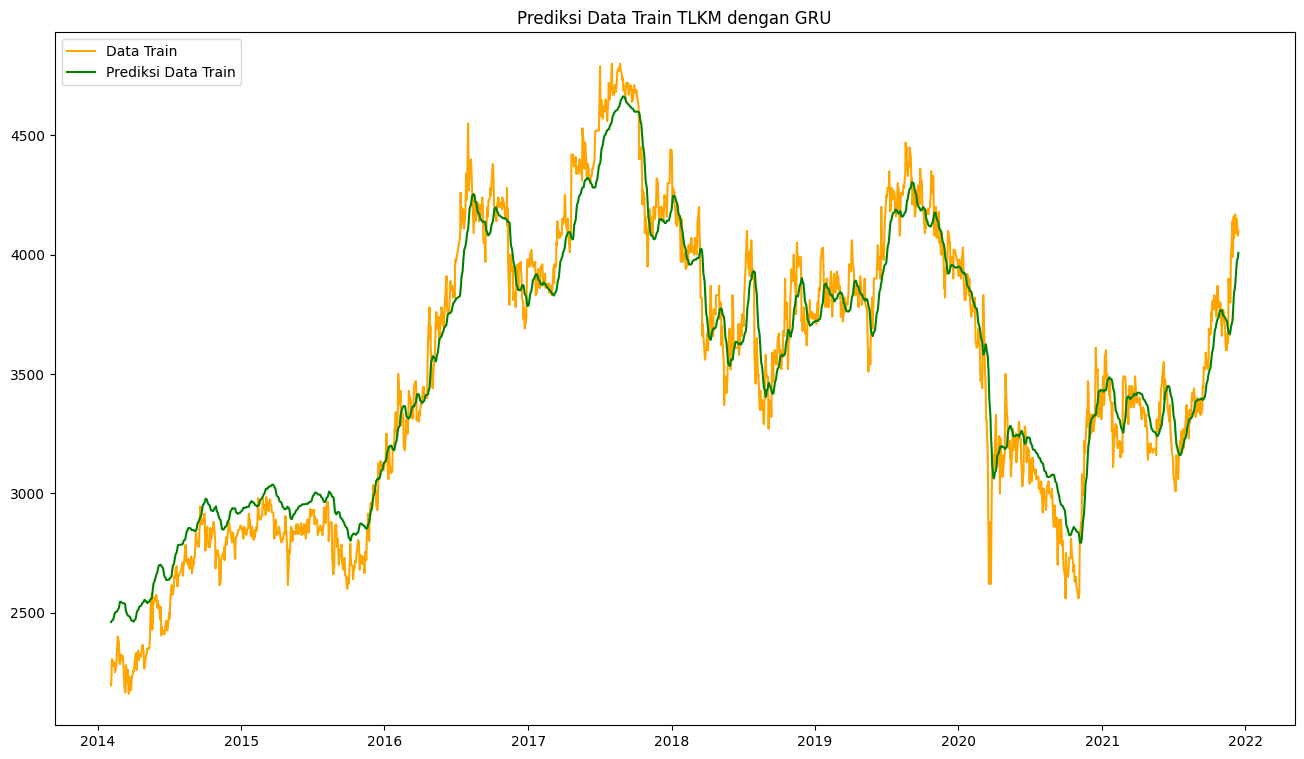

In [ ]:
#plot the predictions for train set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_train_gru.index, data_train_gru, color="orange", label='Data Train')
plt.plot(data_train_gru.index, y_train_pred_gru, color="green", label='Prediksi Data Train')
plt.title('Prediksi Data Train TLKM dengan GRU')
plt.legend(loc="upper left")
plot_train_gru = '/content/drive/My Drive/skripsi/gru/tlkm/train/tlkm_train_gru_6.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_train_gru)
plt.show()

In [ ]:
split_data = data_tlkm.shape[0] * 0.8
data_test_gru = data_tlkm[window_size_gru + 1 + int(split_data):]
tabel_data_test = pd.DataFrame({'Date': data_test_gru.index, 'Data Test': data_test_gru.values})
prediksi_test_gru = pd.DataFrame({'Prediksi Data Test GRU':  y_test_pred_gru.flatten()})
tabel_prediksi_test_gru = pd.concat([tabel_data_test, prediksi_test_gru], axis = 1)
folder_gru = '/content/drive/My Drive/skripsi/gru/tlkm/test/gru_6.csv'
tabel_prediksi_test_gru.to_csv(folder_gru, index=False, mode='a')
tabel_prediksi_test_gru

Date  Data Test  Prediksi Data Test GRU
0    2022-01-14     4190.0             4060.509277
1    2022-01-17     4180.0             4063.583252
2    2022-01-18     4250.0             4069.217773
3    2022-01-19     4250.0             4075.565918
4    2022-01-20     4220.0             4085.122314
..          ...        ...                     ...
471  2023-12-21     3950.0             3869.706055
472  2023-12-22     3960.0             3880.318359
473  2023-12-27     3940.0             3888.769531
474  2023-12-28     3960.0             3895.785889
475  2023-12-29     3950.0             3900.521240

[476 rows x 3 columns]

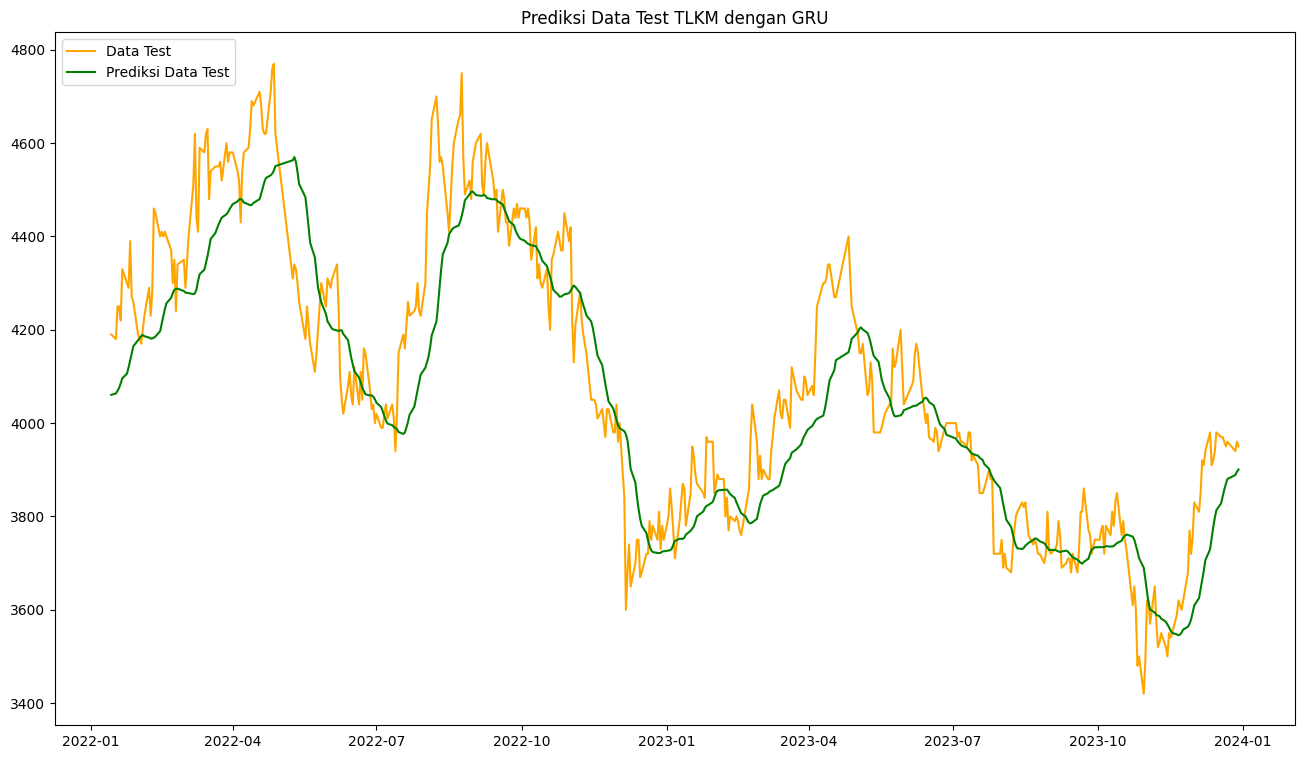

In [ ]:
#plot the predictions for test set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_test_gru.index, data_test_gru, color="orange", label='Data Test')
plt.plot(data_test_gru.index, y_test_pred_gru, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data Test TLKM dengan GRU')
plt.legend(loc="upper left")
plot_test_gru = '/content/drive/My Drive/skripsi/gru/tlkm/test/tlkm_test_gru_6.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_test_gru)
plt.show()

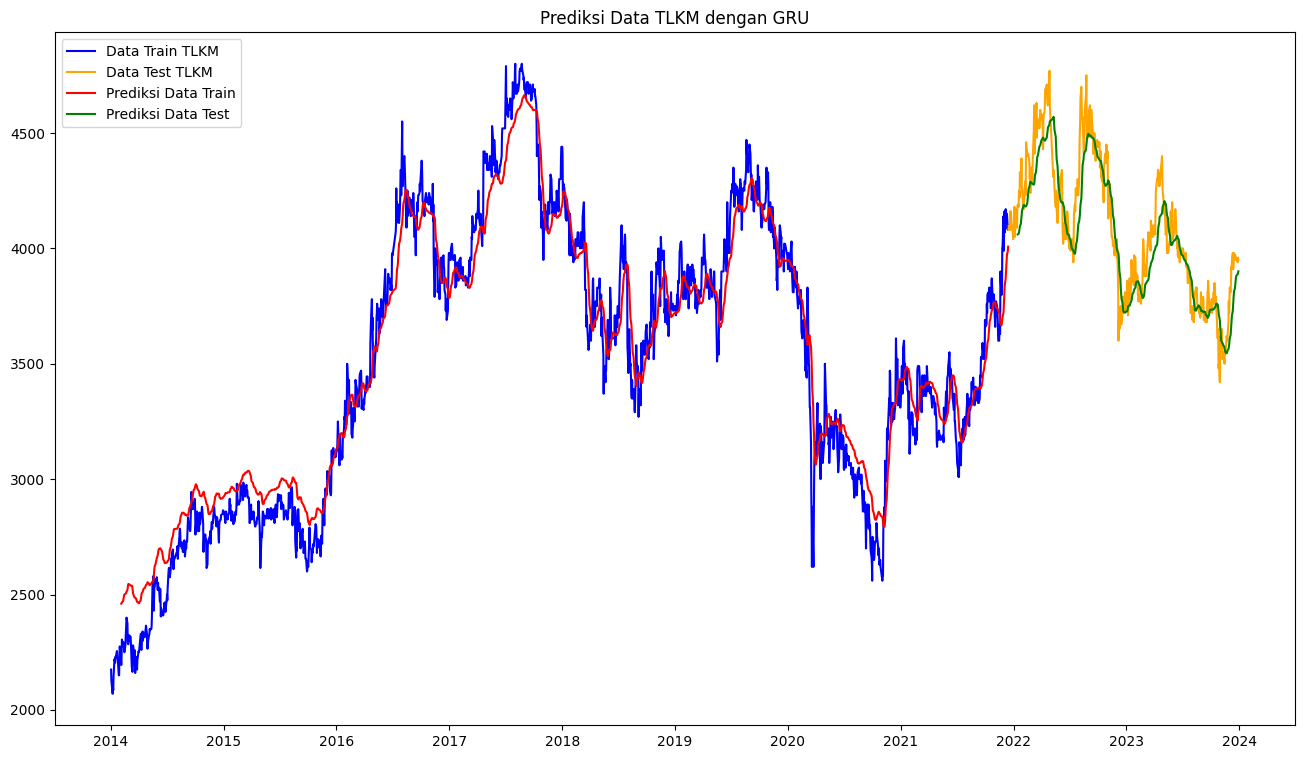

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_tlkm, color="blue", label='Data Train TLKM')
plt.plot(df_test_tlkm, color="orange", label='Data Test TLKM')
plt.plot(data_train_gru.index, y_train_pred_gru, color="red", label='Prediksi Data Train')
plt.plot(data_test_gru.index, y_test_pred_gru, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data TLKM dengan GRU')
plt.legend(loc="upper left")
plot_gru = '/content/drive/My Drive/skripsi/gru/tlkm/plot_gru_6.png'
plt.savefig(plot_gru)
plt.show()

---
## **PSO-GRU**
---

### **Function**

####**Normalisasi Data**

In [ ]:
def normalize_data(df_train_tlkm, df_test_tlkm):
  scaler = MinMaxScaler(feature_range = (0,1))
  train_data_tlkm_norm = scaler.fit_transform(df_train_tlkm.values.reshape(-1,1))
  test_data_tlkm_norm = scaler.transform(df_test_tlkm.values.reshape(-1,1))
  return scaler, train_data_tlkm_norm, test_data_tlkm_norm

####**Window Size**

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        Y.append(data[i + window_size, 0])
    X = np.array(X).reshape(len(X), window_size, 1)
    Y = np.array(Y).reshape(len(Y), 1)
    return X, Y

####**Objective function for PSO-GRU**

In [ ]:
# Objective function for PSO (minimize RMSE)
def objective_function_gru(params, X_train, Y_train, scaler, X_test, Y_test):
  window_size, hidden_layers, epochs, batch_size = params

  print('window_size', window_size, ', hidden_layers', hidden_layers,
          ', epochs', epochs, ', batch_size', batch_size)

  if window_size == 0 or batch_size == 0:
        return 10,

  #GRU model
  model = Sequential()
  model.add(GRU(units=int(hidden_layers), input_shape=(X_train.shape[1], 1),
                 activation='tanh', dropout=0.2))
  model.add(Dense(units=1))
  optimizer = Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss='mean_squared_error')
  #Early Stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                   restore_best_weights=True)
  #Train model
  model.fit(X_train, Y_train, epochs=int(epochs), batch_size=int(batch_size),
            validation_data=(X_test, Y_test), callbacks=[early_stopping])

  #Predictions
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  #RMSE
  rmse = np.sqrt(mse(Y_train, y_train_pred))
  print('Validation RMSE: ', rmse,'\n')
  return rmse

### **Build Model**

####**Normalisasi Data**

In [ ]:
scaler, train_data_tlkm_norm, test_data_tlkm_norm = normalize_data(df_train_tlkm, df_test_tlkm)

####**PSO hyperparameter tuning**

In [ ]:
lb = [10, 25, 1, 1] # Lower bounds for the parameters
ub = [20, 50, 10, 32] #Upper bounds for the parameters

In [ ]:
X_train_psogru, Y_train_psogru = prepare_dataset(train_data_tlkm_norm, lb[0])
X_test_psogru, Y_test_psogru = prepare_dataset(test_data_tlkm_norm, lb[0])
print("X_train: ", X_train_psogru.shape)
print("Y_train: ", Y_train_psogru.shape)
print("X_test: ", X_test_psogru.shape)
print("Y_test", Y_test_psogru.shape)

X_train:  (1974, 10, 1)
Y_train:  (1974, 1)
X_test:  (486, 10, 1)
Y_test (486, 1)


In [ ]:
#Run PSO to optimize hyperparameters
start_time = time.time()
best_params_psogru, best_value_psogru = pso(objective_function_gru, lb, ub, args=(X_train_psogru, Y_train_psogru, scaler, X_test_psogru, Y_test_psogru), swarmsize=5, maxiter=5)
end_time = time.time()
# Print the best parameters found by PSO
print('Best Parameters:', best_params_psogru)
print('RMSE:', best_value_psogru)

window_size 18.41342523660004 , hidden_layers 26.380845734862877 , epochs 2.821756084580032 , batch_size 23.82970983333779
Epoch 1/2
86/86 [==============================] - 4s 17ms/step - loss: 0.3052 - val_loss: 0.3919
Epoch 2/2
16/16 [==============================] - 0s 3ms/step
Validation RMSE:  0.3238715624991823 

window_size 12.660212444313082 , hidden_layers 35.573424284571516 , epochs 1.3165822810795618 , batch_size 20.29058551752527
16/16 [==============================] - 0s 3ms/step
Validation RMSE:  0.10882644335905749 

window_size 12.404740246998996 , hidden_layers 27.845082597261953 , epochs 4.855271214330956 , batch_size 9.779335647687098
Epoch 1/4
220/220 [==============================] - 5s 14ms/step - loss: 0.1138 - val_loss: 0.0373
Epoch 2/4
220/220 [==============================] - 2s 11ms/step - loss: 0.0160 - val_loss: 0.0084
Epoch 3/4
220/220 [==============================] - 2s 8ms/step - loss: 0.0127 - val_loss: 0.0075
Epoch 4/4
16/16 [===================

In [ ]:
optimal_window_size_psogru = int(best_params_psogru[0])
optimal_hidden_layer_psogru = int(best_params_psogru[1])
optimal_epochs_psogru = int(best_params_psogru[2])
optimal_batch_size_psogru = int(best_params_psogru[3])
print('Optimal window size: ', optimal_window_size_psogru)
print('Optimal hidden layer: ', optimal_hidden_layer_psogru)
print('Optimal epoch: ', optimal_epochs_psogru)
print('Optimal batch size: ', optimal_batch_size_psogru)

Optimal window size:  10
Optimal hidden layer:  25
Optimal epoch:  8
Optimal batch size:  5


In [ ]:
X_train_psogru, Y_train_psogru = prepare_dataset(train_data_tlkm_norm, optimal_window_size_psogru)
X_test_psogru, Y_test_psogru = prepare_dataset(test_data_tlkm_norm, optimal_window_size_psogru)
print("X_train: ", X_train_psogru.shape)
print("Y_train: ", Y_train_psogru.shape)
print("X_test: ", X_test_psogru.shape)
print("Y_test", Y_test_psogru.shape)

X_train:  (1974, 10, 1)
Y_train:  (1974, 1)
X_test:  (486, 10, 1)
Y_test (486, 1)


In [ ]:
final_model_psogru = Sequential()
final_model_psogru.add(GRU(units=optimal_hidden_layer_psogru, input_shape=(X_train_psogru.shape[1], 1), activation='tanh', dropout=0.2))
final_model_psogru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.0001)
final_model_psogru.compile(optimizer=optimizer, loss='mean_squared_error')
final_model_psogru.fit(X_train_psogru, Y_train_psogru, epochs=optimal_epochs_psogru, batch_size=optimal_batch_size_psogru, validation_data=(X_test_psogru, Y_test_psogru))
y_train_pred_psogru = final_model_psogru.predict(X_train_psogru)
y_test_pred_psogru = final_model_psogru.predict(X_test_psogru)

Epoch 1/8
395/395 [==============================] - 7s 11ms/step - loss: 0.0664 - val_loss: 0.0065
Epoch 2/8
395/395 [==============================] - 4s 11ms/step - loss: 0.0130 - val_loss: 0.0049
Epoch 3/8
395/395 [==============================] - 3s 9ms/step - loss: 0.0106 - val_loss: 0.0055
Epoch 4/8
395/395 [==============================] - 3s 9ms/step - loss: 0.0095 - val_loss: 0.0046
Epoch 5/8
395/395 [==============================] - 4s 11ms/step - loss: 0.0089 - val_loss: 0.0022
Epoch 6/8
395/395 [==============================] - 4s 11ms/step - loss: 0.0080 - val_loss: 0.0041
Epoch 7/8
395/395 [==============================] - 3s 9ms/step - loss: 0.0070 - val_loss: 0.0031
Epoch 8/8
16/16 [==============================] - 0s 3ms/step


####**Denormalisasi Data**

In [ ]:
# Transform back to original form
y_train_pred_psogru = scaler.inverse_transform(y_train_pred_psogru.reshape(-1,1))
y_test_pred_psogru = scaler.inverse_transform(y_test_pred_psogru.reshape(-1,1))
Y_train_psogru = scaler.inverse_transform(Y_train_psogru.reshape(-1,1))
Y_test_psogru = scaler.inverse_transform(Y_test_psogru.reshape(-1,1))

####**Evaluasi Model**

In [ ]:
def mape(df_test_towr, prediksi):
    return np.mean(np.abs((df_test_towr - prediksi) / df_test_towr)) * 100

#Evaluasi Train Data
r2_train_psogru = r2_score(Y_train_psogru, y_train_pred_psogru)
rmse_train_psogru = np.sqrt(mse(Y_train_psogru, y_train_pred_psogru))
mae_train_psogru = mae(Y_train_psogru, y_train_pred_psogru)
mape_train_psogru = mape(Y_train_psogru, y_train_pred_psogru)
print('R2 pada Train data :', r2_train_psogru)
print('RMSE pada Train data :', rmse_train_psogru)
print('MAE pada Train data :', mae_train_psogru)
print('MAPE pada Train data :', mape_train_psogru)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_psogru = r2_score(Y_test_psogru, y_test_pred_psogru)
rmse_test_psogru = np.sqrt(mse(Y_test_psogru, y_test_pred_psogru))
mae_test_psogru = mae(Y_test_psogru, y_test_pred_psogru)
mape_test_psogru = mape(Y_test_psogru, y_test_pred_psogru)
print('R2 pada Test data :', r2_test_psogru)
print('RMSE pada Test data :', rmse_test_psogru)
print('MAE pada Test data :', mae_test_psogru)
print('MAPE pada Test data :', mape_test_psogru)
print("Training time: "  + str(end_time - start_time))

R2 pada Train data : 0.9350940625681272
RMSE pada Train data : 157.6414836010566
MAE pada Train data : 126.11830357142857
MAPE pada Train data : 3.4762226367679325
------------------------------------------
R2 pada Test data : 0.5528132998930384
RMSE pada Test data : 202.94748526239246
MAE pada Test data : 175.7102352189429
MAPE pada Test data : 4.192362449153865
Training time: 801.9137949943542


In [ ]:
params_psogru = {
    'Window Size': optimal_window_size_psogru,
    'Hidden Layers': optimal_hidden_layer_psogru,
    'Epochs': optimal_epochs_psogru,
    'Batch Size': optimal_batch_size_psogru,
    'R2 Train': r2_train_psogru,
    'RMSE Train': rmse_train_psogru,
    'MAE Train': mae_train_psogru,
    'MAPE Train': mape_train_psogru,
    'R2 Test': r2_test_psogru,
    'RMSE Test': rmse_test_psogru,
    'MAE Test': mae_test_psogru,
    'MAPE Test': mape_test_psogru
}

results_psogru = pd.DataFrame([params_psogru])
folder_psogru = '/content/drive/My Drive/skripsi/pso-gru/tlkm/psogru_results.csv'
results_psogru.to_csv(folder_psogru, index=False, mode='a', header=False)
results_psogru = pd.read_csv('/content/drive/My Drive/skripsi/pso-gru/tlkm/psogru_results.csv')
results_psogru

Window Size  Hidden Layers  Epochs  Batch Size  R2 Train  RMSE Train  \
0           10             25       8           5  0.935094  157.641484   
1           20             35       8           6  0.949460  137.912843   
2           17             28      10          16  0.921165  172.698854   

    MAE Train  MAPE Train   R2 Test   RMSE Test    MAE Test  MAPE Test  
0  126.118304    3.476223  0.552813  202.947485  175.710235   4.192362  
1  109.656721    3.192497  0.767047  147.959654  117.364204   2.810363  
2  145.244378    4.405173  0.681719  172.407185  140.637212   3.331557

###**Comparison Real vs Prediction**

In [ ]:
split_data = data_tlkm.shape[0] * 0.8
data_train_psogru = data_tlkm[optimal_window_size_psogru + 1:int(split_data)]
tabel_data_train = pd.DataFrame({'Date': data_train_psogru.index,  'Data Train': data_train_psogru.values})
prediksi_train_psogru = pd.DataFrame({'Prediksi Data Train PSO-GRU':  y_train_pred_psogru.flatten()})
tabel_prediksi_train_psogru = pd.concat([tabel_data_train, prediksi_train_psogru], axis = 1)
folder_psogru = '/content/drive/My Drive/skripsi/pso-gru/tlkm/train/psogru_1.csv'
tabel_prediksi_train_psogru.to_csv(folder_psogru, index=False, mode='a')
tabel_prediksi_train_psogru

Date  Data Train  Prediksi Data Train PSO-GRU
0    2014-01-20      2250.0                  2335.321045
1    2014-01-21      2255.0                  2346.249756
2    2014-01-22      2230.0                  2360.018555
3    2014-01-23      2225.0                  2372.984863
4    2014-01-24      2210.0                  2380.317871
...         ...         ...                          ...
1969 2021-12-08      4090.0                  3892.611572
1970 2021-12-09      4150.0                  3914.211182
1971 2021-12-10      4150.0                  3927.590332
1972 2021-12-13      4080.0                  3936.752441
1973 2021-12-14      4100.0                  3944.771484

[1974 rows x 3 columns]

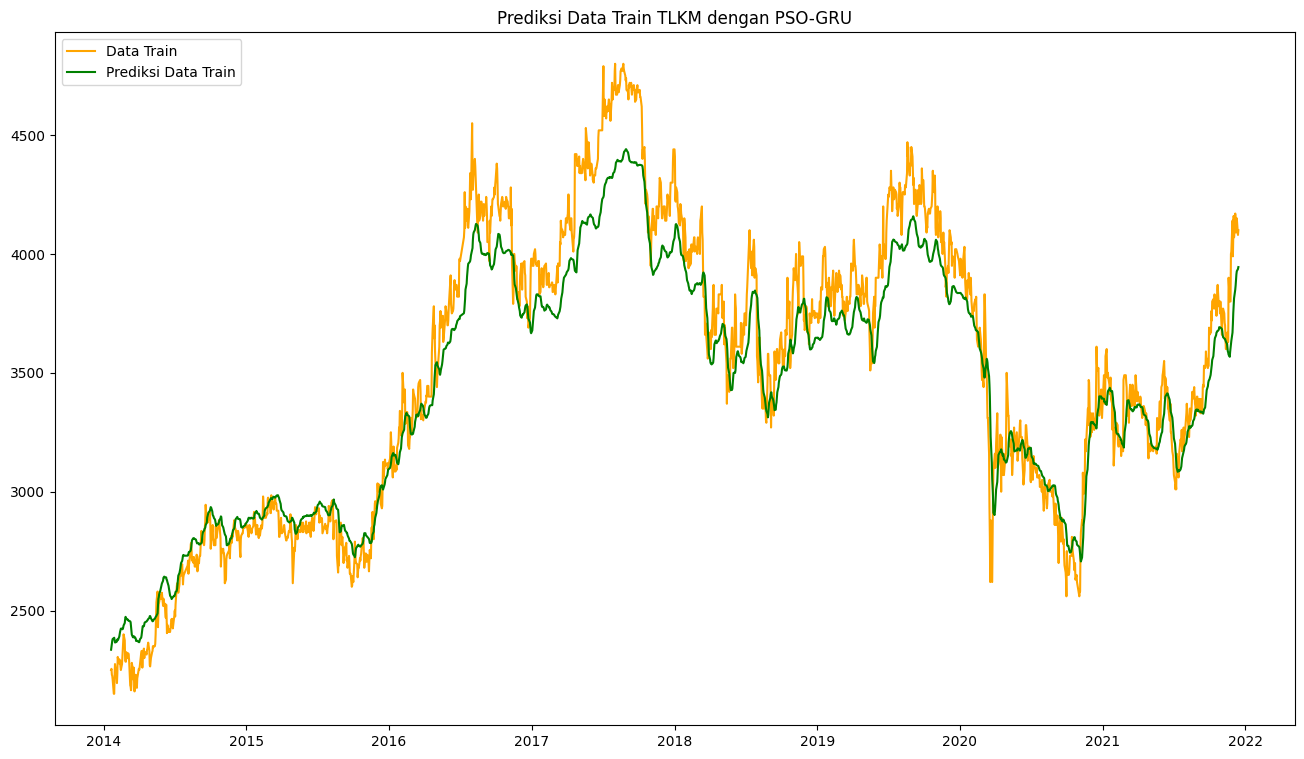

In [ ]:
#plot the predictions for train set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_train_psogru.index, data_train_psogru, color="orange", label='Data Train')
plt.plot(data_train_psogru.index, y_train_pred_psogru, color="green", label='Prediksi Data Train')
plt.title('Prediksi Data Train TLKM dengan PSO-GRU')
plt.legend(loc="upper left")
plot_train_psogru = '/content/drive/My Drive/skripsi/pso-gru/tlkm/train/tlkm_train_psogru_1.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_train_psogru)
plt.show()

In [ ]:
split_data = data_tlkm.shape[0] * 0.8
data_test_psogru = data_tlkm[optimal_window_size_psogru + 1 + int(split_data):]
tabel_data_test = pd.DataFrame({'Date': data_test_psogru.index, 'Data Test': data_test_psogru.values})
prediksi_test_psogru = pd.DataFrame({'Prediksi Data Test PSO-GRU':  y_test_pred_psogru.flatten()})
tabel_prediksi_test_psogru = pd.concat([tabel_data_test, prediksi_test_psogru], axis = 1)
folder_psogru = '/content/drive/My Drive/skripsi/pso-gru/tlkm/test/psogru_1.csv'
tabel_prediksi_test_psogru.to_csv(folder_psogru, index=False, mode='a')
tabel_prediksi_test_psogru

Date  Data Test  Prediksi Data Test PSO-GRU
0    2021-12-30     4040.0                   3935.3398
1    2022-01-03     4180.0                   3932.5894
2    2022-01-04     4170.0                   3925.4248
3    2022-01-05     4050.0                   3930.3794
4    2022-01-06     4120.0                   3937.3857
..          ...        ...                         ...
481  2023-12-21     3950.0                   3806.6500
482  2023-12-22     3960.0                   3810.0034
483  2023-12-27     3940.0                   3811.9702
484  2023-12-28     3960.0                   3813.1760
485  2023-12-29     3950.0                   3811.1497

[486 rows x 3 columns]

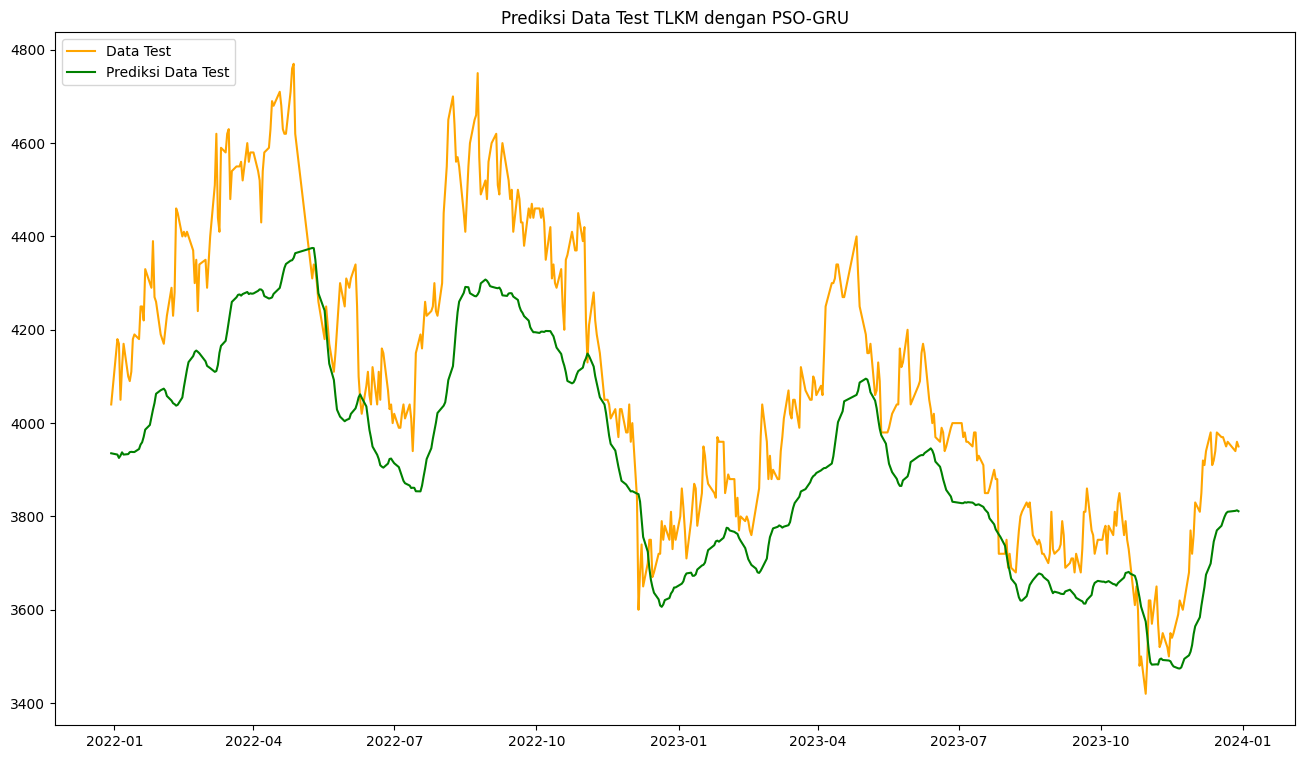

In [ ]:
#plot the predictions for test set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_test_psogru.index, data_test_psogru, color="orange", label='Data Test')
plt.plot(data_test_psogru.index, y_test_pred_psogru, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data Test TLKM dengan PSO-GRU')
plt.legend(loc="upper left")
plot_test_psogru = '/content/drive/My Drive/skripsi/pso-gru/tlkm/test/tlkm_test_psogru_1.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_test_psogru)
plt.show()

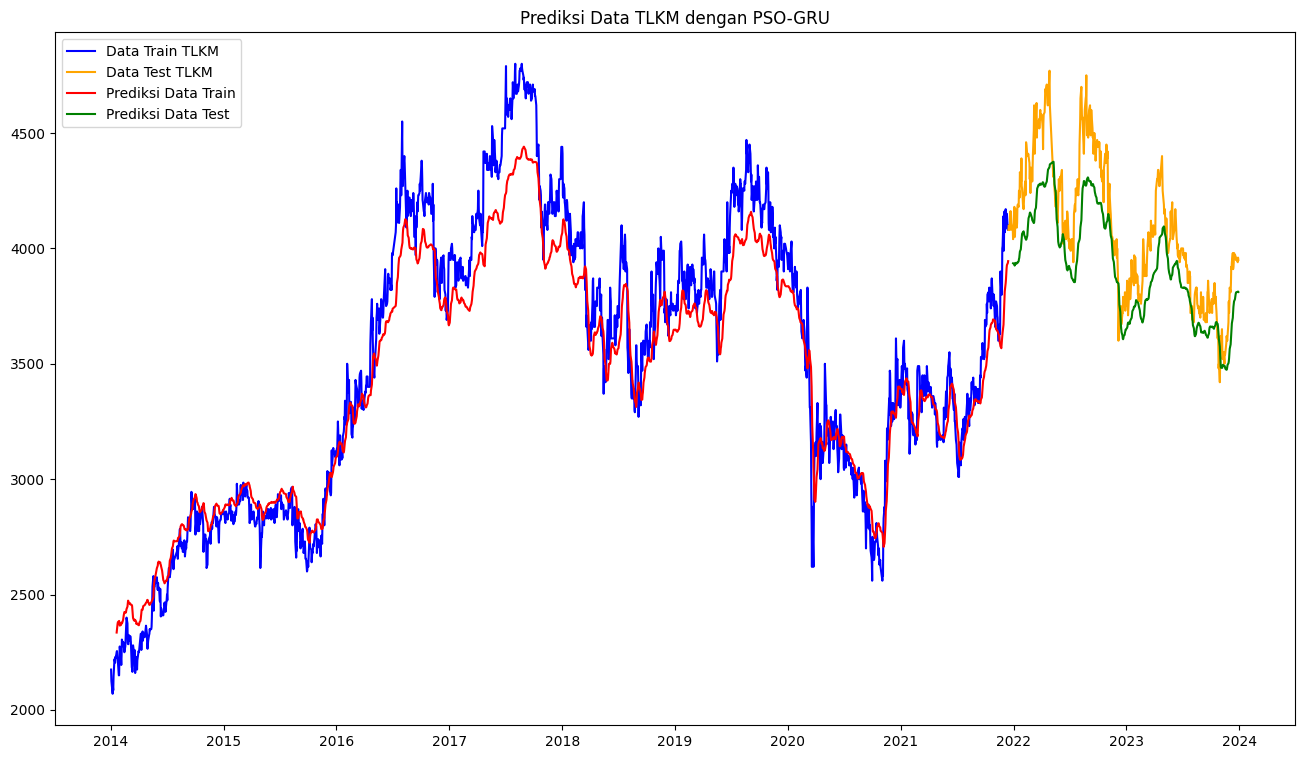

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_tlkm, color="blue", label='Data Train TLKM')
plt.plot(df_test_tlkm, color="orange", label='Data Test TLKM')
plt.plot(data_train_psogru.index, y_train_pred_psogru, color="red", label='Prediksi Data Train')
plt.plot(data_test_psogru.index, y_test_pred_psogru, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data TLKM dengan PSO-GRU')
plt.legend(loc="upper left")
plot_psogru = '/content/drive/My Drive/skripsi/pso-gru/tlkm/plot_psogru_1.png'
plt.savefig(plot_psogru)
plt.show()

---
## **Comparison Auto ARIMA vs LSTM vs PSO-LSTM vs GRU vs PSO-GRU**
---

### **Hyperparameter**

In [ ]:
results_lstm = pd.read_csv('/content/drive/My Drive/skripsi/lstm/tlkm/lstm_results.csv')
results_lstm

Window Size  Hidden Layers  Epochs  Batch Size  R2 Train  RMSE Train  \
0           10             25      10          32  0.922217  172.572526   
1           10             50      10          32  0.941348  149.853951   
2           15             50      10          32  0.926730  166.803814   
3           15             50      10          32  0.955812  129.537693   
4           20             25      10          32  0.928385  164.167661   
5           20             50      10          32  0.960127  122.496334   

   MAPE Train   R2 Test   RMSE Test  MAPE Test  
0    4.422278  0.735149  156.185219   2.795247  
1    3.805619  0.797406  136.600594   2.532032  
2    4.208868  0.750111  152.462059   2.818654  
3    3.094639  0.823851  128.005652   2.375775  
4    4.100685  0.773287  145.964766   2.745772  
5    2.844803  0.844055  121.058621   2.285555

In [ ]:
results_psolstm = pd.read_csv('/content/drive/My Drive/skripsi/pso-lstm/tlkm/psolstm_results.csv')
results_psolstm

Window Size  Hidden Layers  Epochs  Batch Size  R2 Train  RMSE Train  \
0           18             44       9           1  0.955896  129.043279   
1           19             35       7           1  0.950861  136.094791   
2           10             25       5           1  0.957252  127.933319   

    MAE Train  MAPE Train   R2 Test   RMSE Test    MAE Test  MAPE Test  
0   97.281704    2.783616  0.794078  138.820701  108.910265   2.609372  
1  100.642830    2.774283  0.718839  162.380865  124.751170   2.948261  
2  100.770124    2.941763  0.804115  134.319612  102.558332   2.435256

In [ ]:
results_gru = pd.read_csv('/content/drive/My Drive/skripsi/gru/tlkm/gru_results.csv')
results_gru

Window Size  Hidden Layers  Epochs  Batch Size  R2 Train  RMSE Train  \
0           10             25      10          32  0.945074  145.017068   
1           10             50      10          32  0.952515  134.835900   
2           15             25      10          32  0.950981  136.433897   
3           15             50      10          32  0.960617  122.290974   
4           20             25      10          32  0.959474  123.495952   
5           20             50      10          32  0.954188  131.303434   

    MAE Train  MAPE Train   R2 Test   RMSE Test    MAE Test  MAPE Test  
0  119.989814    3.611699  0.765865  146.849366  118.405518   2.822649  
1  111.873458    3.357534  0.790830  138.799861  109.362127   2.593309  
2  109.298725    3.377385  0.846075  119.658338   92.999976   2.231686  
3   99.396756    3.026656  0.858561  114.702662   88.258761   2.109349  
4   96.798015    2.821422  0.810800  133.342892  103.280104   2.461561  
5  104.946305    3.202900  0.842706  121.581033   93.978423   2.262956

In [ ]:
results_psogru = pd.read_csv('/content/drive/My Drive/skripsi/pso-gru/tlkm/psogru_results.csv')
results_psogru

Window Size  Hidden Layers  Epochs  Batch Size  R2 Train  RMSE Train  \
0           10             25       8           5  0.935094  157.641484   
1           20             35       8           6  0.949460  137.912843   
2           17             28      10          16  0.921165  172.698854   

    MAE Train  MAPE Train   R2 Test   RMSE Test    MAE Test  MAPE Test  
0  126.118304    3.476223  0.552813  202.947485  175.710235   4.192362  
1  109.656721    3.192497  0.767047  147.959654  117.364204   2.810363  
2  145.244378    4.405173  0.681719  172.407185  140.637212   3.331557

In [ ]:
tabel_hyperparameter = pd.DataFrame({'Model' : ['LSTM', 'PSO-LSTM', 'GRU', 'PSO-GRU'],
                                     'Window Size' : [results_lstm.loc[5, 'Window Size'], results_psolstm.loc[2, 'Window Size'], results_gru.loc[3, 'Window Size'], results_psogru.loc[1, 'Window Size']],
                                     'Hidden Layers' : [results_lstm.loc[5, 'Hidden Layers'], results_psolstm.loc[2, 'Hidden Layers'],  results_gru.loc[3, 'Hidden Layers'], results_psogru.loc[1, 'Hidden Layers']],
                                     'Epochs' : [results_lstm.loc[5, 'Epochs'], results_psolstm.loc[2, 'Epochs'], results_gru.loc[3, 'Epochs'], results_psogru.loc[1, 'Epochs']],
                                     'Batch Size' : [results_lstm.loc[5, 'Batch Size'], results_psolstm.loc[2, 'Batch Size'], results_gru.loc[3, 'Batch Size'], results_psogru.loc[1, 'Batch Size']]})
tabel_hyperparameter

Model  Window Size  Hidden Layers  Epochs  Batch Size
0      LSTM           20             50      10          32
1  PSO-LSTM           10             25       5           1
2       GRU           15             50      10          32
3   PSO-GRU           20             35       8           6

### **Evaluasi Model**

In [ ]:
tabel_comparison_evaluasi = pd.DataFrame({'Model' : ['R2', 'RMSE',  'MAPE'],
                                          'Train Auto ARIMA' : [r2_train_autoarima, rmse_train_autoarima, mape_train_autoarima],
                                          'Test Auto ARIMA' : [r2_test_autoarima, rmse_test_autoarima, mape_test_autoarima],
                                          'Train LSTM' : [results_lstm.loc[5, 'R2 Train'], results_lstm.loc[5, 'RMSE Train'], results_lstm.loc[5, 'MAPE Train']],
                                          'Test LSTM': [results_lstm.loc[5, 'R2 Test'], results_lstm.loc[5, 'RMSE Test'],  results_lstm.loc[5, 'MAPE Test']],
                                          'Train PSO-LSTM' : [results_psolstm.loc[2, 'R2 Train'], results_psolstm.loc[2, 'RMSE Train'], results_psolstm.loc[2, 'MAPE Train']],
                                          'Test PSO-LSTM': [results_psolstm.loc[2, 'R2 Test'], results_psolstm.loc[2, 'RMSE Test'],  results_psolstm.loc[2, 'MAPE Test']],
                                          'Train GRU' : [results_gru.loc[3, 'R2 Train'], results_gru.loc[3, 'RMSE Train'],  results_gru.loc[3, 'MAPE Train']],
                                          'Test GRU': [results_gru.loc[3, 'R2 Test'], results_gru.loc[3, 'RMSE Test'],  results_gru.loc[3, 'MAPE Test']],
                                          'Train PSO-GRU' : [results_psogru.loc[1, 'R2 Train'], results_psogru.loc[1, 'RMSE Train'],  results_psogru.loc[1, 'MAPE Train']],
                                          'Test PSO-GRU': [results_psogru.loc[1, 'R2 Test'], results_psogru.loc[1, 'RMSE Test'],  results_psogru.loc[1, 'MAPE Test']],
                                 })
tabel_comparison_evaluasi

Model  Train Auto ARIMA  Test Auto ARIMA  Train LSTM   Test LSTM  \
0    R2          0.984378        -0.004811    0.960127    0.844055   
1  RMSE         78.083004       300.936047  122.496334  121.058621   
2  MAPE          1.301487         6.232055    2.844803    2.285555   

   Train PSO-LSTM  Test PSO-LSTM   Train GRU    Test GRU  Train PSO-GRU  \
0        0.957252       0.804115    0.960617    0.858561       0.949460   
1      127.933319     134.319612  122.290974  114.702662     137.912843   
2        2.941763       2.435256    3.026656    2.109349       3.192497   

   Test PSO-GRU  
0      0.767047  
1    147.959654  
2      2.810363

### **Fitted Values**

In [ ]:
fitted_autoarima = pd.read_csv('/content/drive/My Drive/skripsi/auto arima/autoarima_tlkm_fitted.csv', usecols=['Date','Fitted Values'])
fitted_autoarima['Date'] = pd.to_datetime(fitted_autoarima['Date'])
fitted_autoarima['Date'] = fitted_autoarima['Date'].dt.date
fitted_autoarima.set_index('Date', inplace=True)

fitted_lstm = pd.read_csv('/content/drive/My Drive/skripsi/lstm/tlkm/train/lstm_6.csv', usecols=['Date','Prediksi Data Train LSTM'])
fitted_lstm['Date'] = pd.to_datetime(fitted_lstm['Date'])
fitted_lstm['Date'] = fitted_lstm['Date'].dt.date
fitted_lstm.set_index('Date', inplace=True)

fitted_psolstm = pd.read_csv('/content/drive/My Drive/skripsi/pso-lstm/tlkm/train/psolstm_3.csv', usecols=['Date','Prediksi Data Train PSO-LSTM'])
fitted_psolstm['Date'] = pd.to_datetime(fitted_psolstm['Date'])
fitted_psolstm['Date'] = fitted_psolstm['Date'].dt.date
fitted_psolstm.set_index('Date', inplace=True)

fitted_gru = pd.read_csv('/content/drive/My Drive/skripsi/gru/tlkm/train/gru_4.csv', usecols=['Date','Prediksi Data Train gru'])
fitted_gru['Date'] = pd.to_datetime(fitted_gru['Date'])
fitted_gru['Date'] = fitted_gru['Date'].dt.date
fitted_gru.set_index('Date', inplace=True)

fitted_psogru = pd.read_csv('/content/drive/My Drive/skripsi/pso-gru/tlkm/train/psogru_2.csv', usecols=['Date','Prediksi Data Train PSO-GRU'])
fitted_psogru['Date'] = pd.to_datetime(fitted_psogru['Date'])
fitted_psogru['Date'] = fitted_psogru['Date'].dt.date
fitted_psogru.set_index('Date', inplace=True)

tabel_comparison_prediksi = pd.concat([df_train_tlkm, fitted_autoarima,  fitted_lstm, fitted_psolstm, fitted_gru, fitted_psogru], axis = 1)
folder_data_tlkm = '/content/drive/My Drive/skripsi/fitted_data_tlkm.csv'
tabel_comparison_prediksi.to_csv(folder_data_tlkm, index=True, mode='a')
tabel_comparison_prediksi

TLKM  Fitted Values  Prediksi Data Train LSTM  \
2014-01-02  2175.0       1.000000                       NaN   
2014-01-03  2125.0    2175.000000                       NaN   
2014-01-06  2085.0    2127.683664                       NaN   
2014-01-07  2070.0    2094.005330                       NaN   
2014-01-08  2100.0    2076.239770                       NaN   
...            ...            ...                       ...   
2021-12-08  4090.0    4137.649788                 3937.8008   
2021-12-09  4150.0    4096.327946                 3960.7915   
2021-12-10  4150.0    4154.438053                 3977.6638   
2021-12-13  4080.0    4141.849749                 3998.1035   
2021-12-14  4100.0    4084.277215                 4016.8350   

            Prediksi Data Train PSO-LSTM  Prediksi Data Train gru  \
2014-01-02                           NaN                      NaN   
2014-01-03                           NaN                      NaN   
2014-01-06                           NaN                      NaN   
2014-01-07                           NaN                      NaN   
2014-01-08                           NaN                      NaN   
...                                  ...                      ...   
2021-12-08                     3995.2160                3979.6697   
2021-12-09                     4020.8865                4003.0408   
2021-12-10                     4041.3364                4017.9550   
2021-12-13                     4053.3360                4033.7559   
2021-12-14                     4063.4224                4045.5642   

            Prediksi Data Train PSO-GRU  
2014-01-02                          NaN  
2014-01-03                          NaN  
2014-01-06                          NaN  
2014-01-07                          NaN  
2014-01-08                          NaN  
...                                 ...  
2021-12-08                    3855.4602  
2021-12-09                    3880.0066  
2021-12-10                    3899.8772  
2021-12-13                    3921.1470  
2021-12-14                    3941.5190  

[1985 rows x 6 columns]

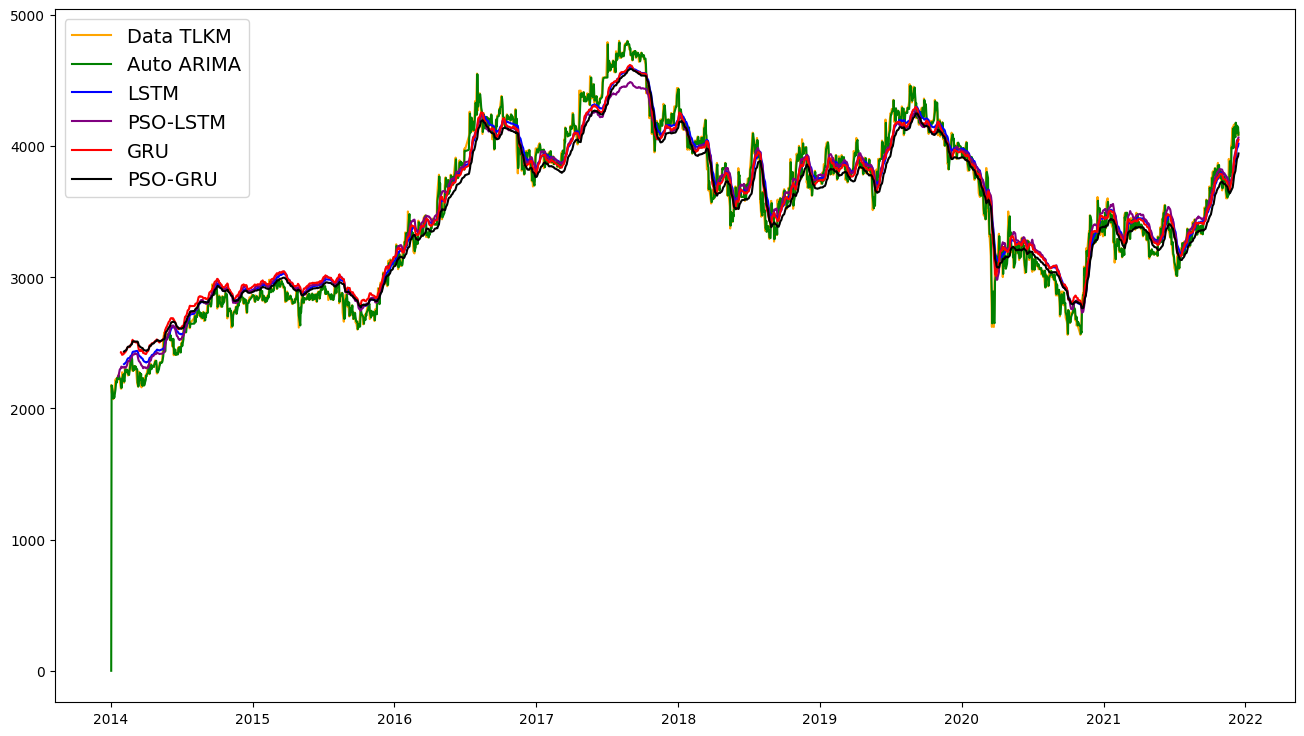

In [ ]:
#plot the fitted values
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_tlkm, color="orange", label='Data TLKM')
plt.plot(fitted_autoarima, color="green", label='Auto ARIMA')
plt.plot(fitted_lstm, color="blue", label='LSTM')
plt.plot(fitted_psolstm, color="purple", label='PSO-LSTM')
plt.plot(fitted_gru, color="red", label='GRU')
plt.plot(fitted_psogru, color="black", label='PSO-GRU')
plt.legend(loc="upper left", fontsize=14)
plt.show()

### **Prediksi**


In [ ]:
prediksi_autoarima = pd.read_csv('/content/drive/My Drive/skripsi/auto arima/autoarima_tlkm_results.csv', usecols=['Date','Prediksi Auto ARIMA'])
prediksi_autoarima['Date'] = pd.to_datetime(prediksi_autoarima['Date'])
prediksi_autoarima['Date'] = prediksi_autoarima['Date'].dt.date
prediksi_autoarima.set_index('Date', inplace=True)

prediksi_lstm = pd.read_csv('/content/drive/My Drive/skripsi/lstm/tlkm/test/lstm_6.csv', usecols=['Date','Prediksi Data Test LSTM'])
prediksi_lstm['Date'] = pd.to_datetime(prediksi_lstm['Date'])
prediksi_lstm['Date'] = prediksi_lstm['Date'].dt.date
prediksi_lstm.set_index('Date', inplace=True)

prediksi_psolstm = pd.read_csv('/content/drive/My Drive/skripsi/pso-lstm/tlkm/test/psolstm_3.csv', usecols=['Date','Prediksi Data Test PSO-LSTM'])
prediksi_psolstm['Date'] = pd.to_datetime(prediksi_psolstm['Date'])
prediksi_psolstm['Date'] = prediksi_psolstm['Date'].dt.date
prediksi_psolstm.set_index('Date', inplace=True)

prediksi_gru = pd.read_csv('/content/drive/My Drive/skripsi/gru/tlkm/test/gru_4.csv', usecols=['Date','Prediksi Data Test GRU'])
prediksi_gru['Date'] = pd.to_datetime(prediksi_gru['Date'])
prediksi_gru['Date'] = prediksi_gru['Date'].dt.date
prediksi_gru.set_index('Date', inplace=True)

prediksi_psogru = pd.read_csv('/content/drive/My Drive/skripsi/pso-gru/tlkm/test/psogru_2.csv', usecols=['Date','Prediksi Data Test PSO-GRU'])
prediksi_psogru['Date'] = pd.to_datetime(prediksi_psogru['Date'])
prediksi_psogru['Date'] = prediksi_psogru['Date'].dt.date
prediksi_psogru.set_index('Date', inplace=True)

tabel_comparison_prediksi = pd.concat([df_test_tlkm, prediksi_autoarima,  prediksi_lstm, prediksi_psolstm, prediksi_gru, prediksi_psogru], axis = 1)
folder_data_tlkm = '/content/drive/My Drive/skripsi/prediksi_data_tlkm.csv'
tabel_comparison_prediksi.to_csv(folder_data_tlkm, index=True, mode='a')
tabel_comparison_prediksi

TLKM  Prediksi Auto ARIMA  Prediksi Data Test LSTM  \
2021-12-15  4080.0          4108.188069                      NaN   
2021-12-16  4100.0          4104.972767                      NaN   
2021-12-17  4100.0          4104.065321                      NaN   
2021-12-20  4080.0          4104.554992                      NaN   
2021-12-21  4160.0          4104.647324                      NaN   
...            ...                  ...                      ...   
2023-12-21  3950.0          4104.576911                3891.2078   
2023-12-22  3960.0          4104.576911                3902.0723   
2023-12-27  3940.0          4104.576911                3911.1980   
2023-12-28  3960.0          4104.576911                3919.7980   
2023-12-29  3950.0          4104.576911                3925.1570   

            Prediksi Data Test PSO-LSTM  Prediksi Data Test GRU  \
2021-12-15                          NaN                     NaN   
2021-12-16                          NaN                     NaN   
2021-12-17                          NaN                     NaN   
2021-12-20                          NaN                     NaN   
2021-12-21                          NaN                     NaN   
...                                 ...                     ...   
2023-12-21                    3933.9658               3902.2280   
2023-12-22                    3936.9692               3909.3618   
2023-12-27                    3940.0193               3913.6270   
2023-12-28                    3941.8070               3916.9302   
2023-12-29                    3938.7234               3918.0156   

            Prediksi Data Test PSO-GRU  
2021-12-15                         NaN  
2021-12-16                         NaN  
2021-12-17                         NaN  
2021-12-20                         NaN  
2021-12-21                         NaN  
...                                ...  
2023-12-21                   3814.9890  
2023-12-22                   3827.0283  
2023-12-27                   3837.3550  
2023-12-28                   3846.6792  
2023-12-29                   3853.2239  

[497 rows x 6 columns]

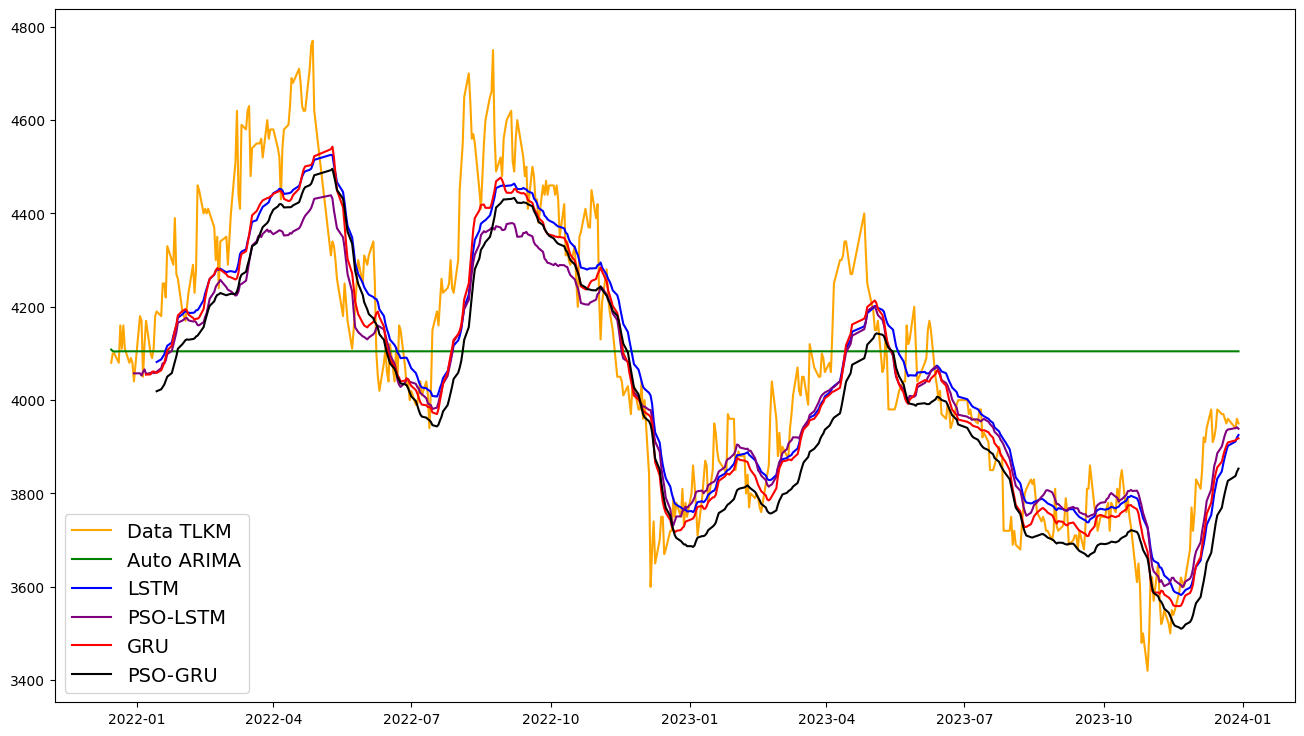

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_test_tlkm, color="orange", label='Data TLKM')
plt.plot(prediksi_autoarima, color="green", label='Auto ARIMA')
plt.plot(prediksi_lstm, color="blue", label='LSTM')
plt.plot(prediksi_psolstm, color="purple", label='PSO-LSTM')
plt.plot(prediksi_gru, color="red", label='GRU')
plt.plot(prediksi_psogru, color="black", label='PSO-GRU')
plt.legend(loc="lower left", fontsize=14)
plt.show()